# AUTOENCODERS
Aprendizaje NO supervisado

El objetivo de estos scripts es desarrollar diferentes alternativas para Autoencoder entrenado con espectogramas. Más concretamente, los espectrogramas provendrán de señales de audio que serán grabaciones de  diferentes escenarios relacionados con el mar, tales como: animales, barcos, ruidos del mar, etc.
Cada especrograma es una matriz de 2 dimensiones, que se puede pensar como una imagen en Blanco y negro. 


### IMPORTAR LIBRERÍAS

In [6]:
## AutoEncoder v1
import os
import numpy as np
import pickle
import tensorflow as tf
#print(tf.__version__)==> VERSION DE TENSORFLOW  1.10
import matplotlib

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.layers import Activation, Lambda, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_squared_error # MeanSquaredError
from tensorflow.keras import metrics
from matplotlib import pyplot as plt
import pickle   #Lo tuve que agregar nuevamente porque me decía que no estaba definido cuando guarda los datos
import skimage   #la version que se instla en conda es la 0.14.0 ==> hay que ver nombre de la funcion para metricas
from skimage import measure 
from sklearn.model_selection import train_test_split 

### DATOS

Los datos están en archivos con extensión npy (numpy). El archivo me devuelve un tensor de 3 dimensiones (FxTxN) , donde N es la cantidad de archivos, F representa las filas y T las columnas.
Existen dos archivos más que son: frecuencia y tiempo. Me sirven para poder visualizar los datos si quisiera. Los datos se encuentran en dB ya que la escala logaritmica permite una mejor visualización. Los datos están normalizados tanto en frecuencia como en tiempo. La frecuencia de re-sample es de 44100 Hz y el tiempo de cada espectograma es de 1 seg. Los espectogramas están realizados sobre audio normalizados entre -1 y 1. La cantidad de muestras de la FFT=256 Los valores devueltos se encuentran entre valores de -150 a 50.


#### CARGA DE LOS DATOS :   
Se carga el archivo. Al cargar el archivo te devuelve un tensor de 3 dimensiones. 
Este es un archivo de TODOS los datos (no hay separación en TRAIN y TEST)

In [15]:
#Pxx=np.load('c:/Users/Celeste/Desktop/Python_proyects/Datos/PECESlog.npy')  #windows mio
#Pxx=np.load('/home/lac073/Escritorio/Programas de Python/DATOS/PECESlog.npy')  #windows mio
##Pxx=np.load('C:/Users/el_lu/Desktop/proyectospython/ballena_franca.npy')  #windows Lucas
#Pxx=np.load('C:/Users/el_lu/Desktop/proyectospython/Datos/peces.npy')  #windows Lucas
Pxx=np.load('C:/Users/el_lu/Desktop/proyectospython/Datos/MYSTICETlog.npy')  #windows Lucas
#Pxx=np.load('/home/lac073/Escritorio/Programas de Python/DATOS/MYSTICETlog.npy') #"linux"
print(np.shape(Pxx)) # para que sepamos la dimensión de todos los datos

(129, 196, 6715)


#### ADECUACIÓN EN LONGITUD DE LOS DATOS  
Es más conveniente para la reconstrucción que la longitud de las columnas y filas sea un número par, ya que los filtros propuestos para la reconstrucción son cuadrados.

In [16]:
#LONGITUD DE LOS DATOS
long_col=len(Pxx[1,:,1])
long_filas=len(Pxx[:,1,1])

if (long_col % 2) !=0 :
   Pxx = Pxx[:,0:-1, :]
if (long_filas % 2) !=0 :
   Pxx = Pxx[0:-1,:, :] 

print (np.shape(Pxx))   

(128, 196, 6715)


#### NORMALIZACIÓN DE LOS DATOS ENTRE 0 y 1:   
Se vuelven a normalizar los datos para que se encuentren en el rango entre 0 a 1. Este paso se realiza porque las funciones definidas por Keras admiten valores
dentro de ese rango

In [17]:
class MinMaxNormalizationSpectograms :
    def __init__ (self, input_data):
        self.np_data = np.array(input_data)
        self.min = np.min(self.np_data)
        self.max = np.max(self.np_data)
    
    def spectograms_to_image (self,input_data):
        self.norm_array = ( self.np_data - self.min)/(self.max-self.min)
        return self.norm_array

P_normalizer = MinMaxNormalizationSpectograms(Pxx)
p_train_norm = P_normalizer.spectograms_to_image(Pxx)

#input_shape=np.shape(x_train_norm)
print(np.shape(p_train_norm ))
#print(input_shape)

(128, 196, 6715)


#### ADECUACIÓN DE LOS DATOS PARA EL ENTRENAMIENTO

In [18]:
import numpy as np
a=len((p_train_norm[:,1,1])) #Cantidad de filas
b=len((p_train_norm[1,:,1])) #Cantidad de columnas
c=len((p_train_norm[1,1,:])) #Cantidad de cantidadd de archivos

Pxx=np.reshape(p_train_norm,(c,a,b, 1))
print(np.shape(Pxx))

(6715, 128, 196, 1)


#### DIVISIÓN ALEATORIA

In [19]:
x_train, x_test = train_test_split(Pxx, test_size = 0.10)
print(np.shape(x_test))
print(np.shape(x_train))

#Forma adecudad de la dimension de los datos de entrada
input_shape=np.shape(x_train)
print(input_shape)

(672, 128, 196, 1)
(6043, 128, 196, 1)
(6043, 128, 196, 1)


## AUTOENCODER_CNN

Esta primera versión de Autoencoder se basará en arquitecturas CNN. Se utilizará una definición por clases, utilizando la librería Tensorflor (más específicamente Keras)

### ARQUITECTURA DEL AUTOENCODER :  
La presente clase se refiere a una arquitectura Deep CNN AutoEncoder en la que se espejan los componentes del 
codificador y el decodificador.

In [110]:
#DEFINICIÓN DE LA CLASE AUTOENCODER. 

class AutoEncoder:

    def __init__(self,
                 input_shape,   # Dimensión de los datos de entrada. En este caso, espectogramas 2D.
                 conv_filters,  # Cantidad de filtros de convolución de cada capa.
                 conv_kernels,  # Dimensions de los filtros convolucionales. De por sí, estos filtros se piensan en 
                                # 2D porque la entrada es 2D y se definirá así. En este caso, las dimensiones de las 
                                # filas=columnas.
                 conv_strides,  # El corrimiento en la convolución del filtro con la entrada.
                 latent_space_dim): #Dimensión del espacio latente utilizado como  bottleneck entre encoder and decoder
   
        self.input_shape = input_shape # Cada  entradas individualmente tendrá la dimensión [196,128,1]  
        self.conv_filters = conv_filters # [2, 4, 8] 
        self.conv_kernels = conv_kernels # [3, 5, 3] ==> (3x3x1,5x5x1,3x3x1)
        self.conv_strides = conv_strides # [1, 2, 2]
        self.latent_space_dim = latent_space_dim #
        self.Encoder = None
        self.Decoder = None
        self.Model = None
        self._model_input = None
        self._num_conv_layers = len(conv_filters) # Número de capas convolucionales en el modelo.
        self._shape_before_bottleneck = None
      
        
        self._build() #Método para crear el Modelo

  #Definición del Método para crear los modelos
    def _build(self):
        self._build_encoder() #Crear  modelo de codificador
        self._build_decoder()  #Crear  modelo de decodificador
        self._build_autoencoder() #crear modelo unificado

  #----------------------------------------------------------------------------------------
  #                   ENCODER
  #---------------------------------------------------------------------------------------
  #Se define la construcción del codificador
    def _build_encoder(self):
        encoder_input = self._add_encoder_input() #Add input layer
        conv_layers = self._add_conv_layers(encoder_input) #Add all conv layers
        bottleneck = self._add_bottleneck(conv_layers) #Agrega el cuello de botella
        self._model_input = encoder_input 
        self.Encoder = Model(encoder_input, bottleneck, name='Encoder_v1') # El modelo se crea con la entrada, la salida bottleneck

    def _add_encoder_input(self):
        return Input(
            shape = self.input_shape,
            name = "Encoder_Input_layer"
            )

    def _add_conv_layers(self, temp_model):
        #Creation of all convolutional layers in the model.#
        aux = temp_model
        #Add layer to layer to the model
        for layer in range(self._num_conv_layers):
            aux = self._add_conv_layer(layer,aux)
        return aux

    def _add_conv_layer(self, layer, temp_model):
    #Agregue capass convolucionales al modelo (temp_model). Cada capa convolucional consiste en:
    #- Conv2D: convolución con filtros 2D.
    #- ReLU : función de activación aplicada al resultado de la convolución.
    #- BatchNromalzation : Esta operación se agrega como capa de Subsampling o Pooling (capa de reducción de parámetros). Esta operación acelera el proceso de entrenamiento.
        # Cada capa de una red neuronal tiene entradas con una distribución correspondiente,que se ve afectada durante el proceso de entrenamiento por 
        # la aleatoriedad en la inicialización de parámetros y la aleatoriedad en los datos de entrada. 
        # El efecto de estas fuentes de aleatoriedad en la distribución de las entradas  produce cambios en las medias y las varianzas de las entradas 
        # a las capas internas durante el entrenamiento. 
        # Durante la etapa de entrenamiento de las redes, a medida que cambian los parámetros de las capas anteriores, la distribución de entradas a la capa cambia,
        # de modo que la capa actual necesita reajustarse constantemente a las nuevas distribuciones. Este problema aumenta en redes profundas, 
        # ya que los pequeños cambios en las capas ocultas menos profundas se amplificarán a medida que se propaguen dentro de la red.. 
        # Por lo tanto, se propone el método de normalización por lotes para reducir estos cambios no deseados para acelerar el entrenamiento y 
        # producir modelos más confiables.
        # La normalización por lotes parece tener un efecto de regularización, de modo que la red mejora sus propiedades de generalización.
        # También se ha observado que, con la norma por lotes, la red se vuelve más robusta a diferentes esquemas de inicialización y tasas de aprendizaje.
    #- El padding se ajusta para obtener a la salida de cada convoloción, las matrices adecuadas.
    
        layer_num = layer + 1
        conv_layer = Conv2D(
            filters=self.conv_filters[layer],
            kernel_size=self.conv_kernels[layer],
            strides=self.conv_strides[layer],
            padding="same", #Esta opción habilita para que se agrega padding de forma automática.
            name="encoder_conv_layer_"+str(layer)
            )
        temp_model = conv_layer(temp_model)
        temp_model = ReLU(name="encoder_ReLU_layer_"+str(layer))(temp_model)
        temp_model = BatchNormalization(name="encoder_BN_layer_"+str(layer))(temp_model)
        return temp_model
    
    def _add_bottleneck(self, temp_model):
    #- Se agrega una capa densa (totalmente conectada) al modelo, para obtener el espacio latente.
    #- Se debe agregar una capa Flatten para remodelar el tensor de salida de las capas convolucionales a un vector adecuado para una capa Densa.
    #- Se almacena información sobre la forma del modelo, antes de almacenar el espacio latente, para el proceso de duplicación mientras se construye el decoder. 
    #- Se guarda el modelo para poder replicar en el decoder.
        self._shape_before_bottleneck = K.int_shape(temp_model)[1:]
        temp_model = Flatten()(temp_model) #Se agrega una capa Flatten para obtener una matriz representativo. 
        temp_model = Dense(self.latent_space_dim, name="Encoder_output")(temp_model)
        return temp_model

  #------------------------------------------------------------------------------------------------------------------------------
  #                   DECODER
  #------------------------------------------------------------------------------------------------------------------------------
    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.Decoder = Model(decoder_input, decoder_output, name="Decoder_v1")

    def _add_decoder_input(self):
        return Input(
            shape = (self.latent_space_dim,),   #Acá va a así
            name = "Decoder_input_layer"
        )

    def _add_dense_layer(self, temp_model):
        dense_layer = Dense(
            np.prod(self._shape_before_bottleneck),
            name = "Decoder_dense_layer"
            )(temp_model)
        return dense_layer

    def _add_reshape_layer(self,temp_model):
        return Reshape(self._shape_before_bottleneck)(temp_model)

    def _add_conv_transpose_layers(self, temp_model):
        # Add all the transpose convolutional layers to the model"""
        for layer in reversed(range( 1, self._num_conv_layers)):
              temp_model = self._add_conv_transpose_layer(layer,temp_model)
        return temp_model

    def _add_conv_transpose_layer(self,layer,temp_model):
        #"Add a single transpose conv layer to the model """
        layer_num = self._num_conv_layers - layer
        conv_transpose_layer = Conv2DTranspose(
            filters = self.conv_filters[layer],
            kernel_size=self.conv_kernels[layer],
            strides=self.conv_strides[layer],
            padding="same",
            name="decoder_conv_transpose_layer_"+str(layer) #Las F string son válidas  a partir de Python 3.6
            )
        temp_model = conv_transpose_layer(temp_model)
        temp_model = ReLU(name ="decoder_ReLU_transpose_layer_"+str(layer))(temp_model)
        temp_model = BatchNormalization(name = "decoder_BN_transpose_layer_"+str(layer))(temp_model)
        return temp_model

    def _add_decoder_output(self, temp_model):
        conv_transpose_layer = Conv2DTranspose(
            filters=1,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name="decoder_conv_transpose_layer_"+str(self._num_conv_layers)
            )
        temp_model = conv_transpose_layer(temp_model)
        output_layer = Activation("sigmoid", name="sigmoid_layer")(temp_model)
        return output_layer

  #----------------------------------------------
  #                   AUTOENCODER
  #----------------------------------------------
    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.Decoder(self.Encoder(model_input))
        self.Model = Model(model_input, model_output, name="AutoEncoder_CNN")

  #----------------------------------------------------------------------------------------------------------------------
  #            COMPILATION AND TRAINING
  #----------------------------------------------------------------------------------------------------------------------
    # Al compilar, debemos especificar algunas propiedades adicionales necesarias para la formación de la red. 
    # Entrenar una red significa encontrar el mejor conjunto de pesos para que la red haga lo que debe hacer. 
    # Debemos especificar la función de pérdida a utilizar para evaluar un conjunto de pesos, el optimizador utilizado para buscar a través de diferentes pesos para la red. 
    # y si quisiecemos podríamos agregar cualquier métrica opcional que nos gustaría recopilar y reportar durante el entrenamiento.
    # Para el entrenamiento se utiliza el error cuadrado medio como función de pérdida y un tipo de optimizador denominada Adam.
    # Aam es un algoritmo de optimización de reemplazo para el descenso de gradiente estocástico para entrenar modelos de aprendizaje profundo.

    def compile(self, learning_rate=0.0001):
        optimizer = Adam(lr=learning_rate)
        mse_loss = mean_squared_error
        self.Model.compile(optimizer=optimizer, loss=mse_loss)
    
    #Hemos definido nuestro modelo y lo hemos compilado listo para un cálculo eficiente. Ahora es el momento de ejecutar el modelo sobre algunos datos. 
    #Podemos entrenar o ajustar nuestro modelo a los datos cargados llamando a la función fit() en el modelo.
    # El proceso de entrenamiento se ejecutará para un número fijo de iteraciones denominado epochs o épocas. 
    # También podemos establecer el número de instancias que se evalúan antes de que se realice una actualización de peso en la red llamada batch_size 
    # Para este problema utilizaremos un pequeño número de epochs (150) y un batch_size relativamente pequeño (10). 
    # Estos pueden ser elegidos experimentalmente por ensayo y error.
    #Esta función me devuelve un atributo de History. Si, en vez de utilizar para valiadción un porcentaje de los datos,
    #quisiera utilizar datos, entonces, debería cambiar porcentaje_valiacion por datos_validation= (x_test,x_test). Es decir que debno poner los datos
    #de test y el target.
    def train(self, x_train, batch_size, num_epochs,porcentaje_validacion):
        History = self.Model.fit(x_train,
                                x_train,
                                batch_size=batch_size,
                                epochs=num_epochs,
                                validation_split=porcentaje_validacion, #Indica el porcentaje de datos de train que se usarán para validación
                                shuffle=True)
        return History

  #----------------------------------------------
  #                   EVALUACIÓN DEL MODELO  
  #----------------------------------------------   
    #Esta función me devuelve Devuelve el valor de pérdida y los valores de métricas del modelo en modo de prueba.
    def evaluation(self,x_test):  
        evaluacion=self.Model.evaluate(
               x=x_test,
               y=x_test,
               verbose=1
               )
        return evaluacion

  #----------------------------------------------
  #                   STRUCTURE SUMMARY
  #----------------------------------------------

    def summary(self):
        self.Encoder.summary()
        self.Decoder.summary()
        self.Model.summary()

  #----------------------------------------------
  #                  GUARDAR EL MODELO
  #----------------------------------------------
    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
            parameters = [
              self.input_shape,
              self.conv_filters,
              self.conv_kernels,
              self.conv_strides,
              self.latent_space_dim
              ]
            save_path = os.path.join(save_folder, "parameters.pkl")
            with open(save_path, "wb") as f:
                pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5py")  #En versiones posteriores, la extensión podría ser .h5
        self.Model.save_weights(save_path)

  #----------------------------------------------
  #                  CARGAR EL MODELO
  #----------------------------------------------
    def load_weights(self, weights_path):
        self.Model.load_weights(weights_path)

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = AutoEncoder(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5py") #En versiones posteriores, la extensión podría ser .h5
        autoencoder.load_weights(weights_path)
        return autoencoder

  #----------------------------------------------
  #                   PREDICTION
  #----------------------------------------------
  #Reconstrucción de las  imagenenes de entrada
  #Esta función devuelve un tensor de 2 dimensiones:
  # - En la dimension 1 recostruirá una matriz de espectrograma, a partir de una matriz (dato) a la entrada.
  #     La forma de los datos de entrada será un tensor de 4 dimensiones. La salida será también un tensor de 4 dimensiones.
  #     Es decir, si se ingresa con n cantidad de imagenes (n,x,y,1), la salida será un tensor (n,x1,y1,1)
  # - En la dimensión 2, devuelve el tensor de espacio latente. En este tipo de convolucionales, el espacio latente es discreto, 
  #     por lo tanto devolverá un vector por cada imagne ingresada. 

  #Se utiliza con algún dato de test para corroborar la similitud.Luego se podría calcular algún tipo de error.
  #el la posición 1 del tensor se encuentra el espacio latente.
    def reconstruct(self, images):
        latent_representations = self.Encoder.predict(images)
        reconstructed_images = self.Decoder.predict(latent_representations)
        return reconstructed_images, latent_representations
 

### ARQUITECTURA ESPECÍFICA DE LA RED 
Esta arquitectura posee una sección de codificación basada en redes convolucionales, en la que se realiza una
sección de extracción de características y una capa flatten densamente conectadad para obtener una matriz 
representativa o código generador.
A partir de ese codigo generador y replicando a la inversa el proceso de codificación se intenta replicar 
el espectograma de entrada.

La arquitectura propuesta posee en la etapa de extracción de características 4 capas.
En todas las etapas la función de activación es tipo RELU y el padding, asociado a la etapa de filtrado, 
se reacomoda de forma automática para que a la salida de la etapa de filtrado, el tamaño de las filas 
y columnas sea un número entero.
Se agrega una capa de BachNormalization,como capa Pooling.
Se agrega una capa Flatten para obtener un vector de datos representativo.
- 1º capa:  32 Filtros de 3x3x1. El Stride será de 1 y el padding se acomoda.
- 2º capa:  64 Filtros de 3x3x1. El Stride será de 2 y el padding se acomoda.
- 3º capa:  64 Filtros de 3x3x1. El Stride será de 2 y el padding se acomoda.
- 4º capa:  64 Filtros de 3x3x1. El Stride será de 1 y el padding se acomoda.

In [28]:
autoencoder_CNN = AutoEncoder(
            input_shape=(input_shape[0],input_shape[1], 1), #Tamaño de los datos x_train_norm. 
            conv_filters=(32, 64, 64, 64),  #Cantidad de filtros de convolusión de cada capa.
            conv_kernels=(3, 3, 3, 3),   # Dimension de los filtros convolucionales. En este caso, todos serán iguales.
            conv_strides=(1, 2, 2, 1),  #Corrimiento realizado en la convolución, entre el filtro y la entrada, por capa.
            latent_space_dim = 2 #Dimensión del espacio latente 
            )
autoencoder_CNN.summary()  #muestra resumen de arquitectura

Model: "Encoder_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_Input_layer (InputLa [(None, 128, 196, 1)]     0         
_________________________________________________________________
encoder_conv_layer_0 (Conv2D (None, 128, 196, 32)      320       
_________________________________________________________________
encoder_ReLU_layer_0 (ReLU)  (None, 128, 196, 32)      0         
_________________________________________________________________
encoder_BN_layer_0 (BatchNor (None, 128, 196, 32)      128       
_________________________________________________________________
encoder_conv_layer_1 (Conv2D (None, 64, 98, 64)        18496     
_________________________________________________________________
encoder_ReLU_layer_1 (ReLU)  (None, 64, 98, 64)        0         
_________________________________________________________________
encoder_BN_layer_1 (BatchNor (None, 64, 98, 64)        2

### CARGAR EL MODELO

In [151]:
#Este paso se agrega si se quiere seguir enetrenanado un modelo ya guardado
#Cargar el modelo
#autoencoder_CNN = AutoEncoder.load("C:/Users/el_lu/Desktop/proyectospython/modelo_CNN_70_40_4_(20)")  #carga el modelo WINDOWS
autoencoder_CNN = AutoEncoder.load("C:/Users/el_lu/Desktop/proyectospython/Autoencoders/Arquitecturas/CNNs/modelo_CNN_70_40_4_(20)")
#C:\Users\el_lu\Desktop\proyectospython\Autoencoders\Arquitecturas\CNNs\modelo_CNN_70_40_4_(20)
#autoencoder2.summary()  #muestra el modelo
#autoencoder2 = AutoEncoder.load("/home/lac073/Escritorio/Programas de Python/Autoencoders/Modelo_CNN_simple")  #carga el modelo LINUX

### ENTRENAMIENTO

In [12]:
#DATOS NECESARIOS PARA EL ENTRENAMIENTO
LEARNING_RATE = 0.0005
BATCH_SIZE = 70
EPOCHS = 30

porcentaje_validacion=0.2 #porcentaje de datos de entrenamiento destinado a la validación

#COMPILACIÓN Y ENTRENAMIENTO
#En la etapa de compilación se especifican propiedades adicionales necesarias para la formación de la red. 
# La función de pérdida a utilizar para evaluar un conjunto de pesos y el optimizador utilizado para buscar a través de diferentes pesos para la red, 
#ya están definidos anteriormente y son: 
 # - el error cuadrado medio como función de pérdida 
 # - el optimizador Adam. Adam es un algoritmo de optimización de reemplazo para el descenso de gradiente estocástico para entrenar modelos de aprendizaje profundo.
# sólo queda especificar la taza de aprendizaje.
autoencoder_CNN.compile(LEARNING_RATE)

#ENTRENAMIENTO
 # Entrenar una red significa encontrar el mejor conjunto de pesos para que la red haga lo que debe hacer. Es el momento de ejecutar el modelo sobre algunos datos. 
    # El proceso de entrenamiento se ejecutará para un número fijo de iteraciones denominado epochs o épocas. 
    # El número de instancias que se evalúan antes de que se realice una actualización de peso en la red llamada batch_size 
    # Estos pueden ser elegidos experimentalmente por ensayo y error.
    # el porcentaje de validación, indica que porcentada de los datos de train se usan para validar.
#Esta función me devuelve un atributo de History. Si, en vez de utilizar para valiadción un porcentaje de los datos,
#quisiera utilizar datos, entonces, debería cambiar porcentaje_valiacion por datos_validation= (x_test,x_test). Es decir que debno poner los datos
#de test y el target.
History=autoencoder_CNN.train(x_train,BATCH_SIZE,EPOCHS,porcentaje_validacion)


Epoch 1/30
70/70 [==============================] - 223s 3s/step - loss: 0.0496 - val_loss: 0.0393
Epoch 2/30
70/70 [==============================] - 218s 3s/step - loss: 0.0298 - val_loss: 0.0446
Epoch 3/30
70/70 [==============================] - 219s 3s/step - loss: 0.0240 - val_loss: 0.0525
Epoch 4/30
70/70 [==============================] - 219s 3s/step - loss: 0.0200 - val_loss: 0.0432
Epoch 5/30
70/70 [==============================] - 218s 3s/step - loss: 0.0182 - val_loss: 0.0501
Epoch 6/30
70/70 [==============================] - 218s 3s/step - loss: 0.0156 - val_loss: 0.0429
Epoch 7/30
70/70 [==============================] - 219s 3s/step - loss: 0.0148 - val_loss: 0.0326
Epoch 8/30
70/70 [==============================] - 218s 3s/step - loss: 0.0128 - val_loss: 0.0379
Epoch 9/30
70/70 [==============================] - 218s 3s/step - loss: 0.0125 - val_loss: 0.0271
Epoch 10/30
70/70 [==============================] - 218s 3s/step - loss: 0.0116 - val_loss: 0.0209
Epoch 11/

### GUARDAR MODELO

In [144]:
#Guarda el modelo
#autoencoder_CNN.save("C:/Users/Celeste/Desktop/Python_proyects/Autoencoders/modelo_CNN")  #especificar carpeta WINDOWS
autoencoder_CNN.save("C:/Users/el_lu/Desktop/proyectospython/CNN_ballenafranca_transfers5")

### GUARDAR VECTOR DE ERRORES

In [145]:
error_train=History.history["loss"]
error_train_save=np.save('C:/Users/el_lu/Desktop/proyectospython/vectores_error/train_CNN_franca_transfers5.npy', error_train)

error_validation=History.history["val_loss"]
error_validation_save=np.save('C:/Users/el_lu/Desktop/proyectospython/vectores_error/val_CNN_franca_transfers5.npy',error_validation)

### EVALUACIÓN DEL ENTRENAMIENTO

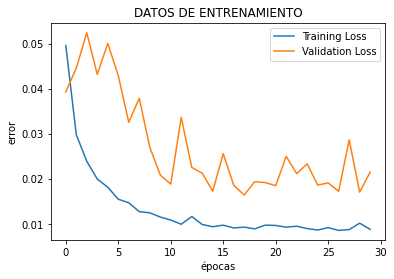

In [13]:
#En esta etapa se utilizarán los datos de validación para evaluar el entrenamiento. Los datos de validación son un porcentaje 
# de los datos de entrenamiento destinados a seguir la evolución del entrenamiento. Estos datos no participan del entrenamiento.
# Se generan gráficos que sirven para evaluar el entrenamiento: overfiting

fig = plt.figure()
plt.title("DATOS DE ENTRENAMIENTO")
plt.ylabel('error')
plt.xlabel('épocas')
plt.plot(History.history["loss"], label="Training Loss")
plt.plot(History.history["val_loss"], label="Validation Loss")
plt.legend()


### EVALUACION DE LA IMAGEN FINAL CON DATOS DE TEST
En esta parte se evaluará con algún dato de test, la similitud entre las imagenes ingresadas y las obtenidas.
Para la evaluación se utilizán dos métricas distintas:
-  El índice SSIM (medida del índice de similitud estructural). SSIM se utiliza para medir la similitud entre dos imágenes. 
El índice SSIM es una métrica de referencia completa; en otras palabras, la medición o predicción de la calidad de la imagen se basa en una imagen inicial sin comprimir o sin distorsiones como referencia.
SSIM es un modelo basado en la percepción que considera la degradación de la imagen como un cambio percibido en la información estructural, al mismo tiempo que incorpora importantes fenómenos de percepción, incluidos los términos de enmascaramiento de luminancia y enmascaramiento de contraste. La diferencia con otras técnicas como MSE o PSNR es que estos enfoques estiman errores absolutos. La información estructural es la idea de que los píxeles tienen fuertes interdependencias, especialmente cuando están espacialmente cerca. Estas dependencias llevan información importante sobre la estructura de los objetos en la escena visual. 
- El error cuadratico medio,

##### Adecuación de la imagen original de TEST.  

In [118]:
#-------Se carga 1 SOLA imagen del conjunto de TEST y se la adecua para ingresar a la funcion que cuantifica el error.---
#Cargamos las imagenes a comparar. Esto carga UNA SOLA IMAGEN  del conjunto de TEST.

N=40
original_test=x_test[N,:]                   #N° imagen comparada: dimensión de los datos de entrada de test es: (128, 196, 1) y tipo array.
imagen_original= np.float32(original_test)  #Paso a float 32 para evitar un  warning que sale al comparar la imagen original con la reconstruida.

#Esta función me devuelve una tupla que contiene en: -[0] un tensor de todas las imagenes reconstruídas y en [1] la/las imagen/es codigo en el espacio latente.
    #La dimensión del dato de entrada debe ser (n,x,y,1), siendo n la cantidad de imagenes que se generan a la salida.
    #Para que sólo ingrese una imagen y se genere un sólo código, se debe agregar una cuarta dimension.
#imagen_original_4dim_tensor=tf.expand_dims(imagen_original, axis=0) #Esta función me devuelve un tensor, asique se debe pasar a array.
#imagen_original_4dim = tf.compat.v1.Session().run(imagen_original_4dim_tensor)

##### Calculo de errores con 1 imagen de TEST

In [119]:
# print('En la posición RESULTADO[0] se encuentra el tensor de imagenes, cuya dimensión es:',np.shape(tratadas_todas[0]))
# print('En la posición RESULTADO[1] se encuentra el tensor del espacio latente, cuya dimensión es:',np.shape(tratadas_todas[1]))
#RESULTADO=autoencoder_CNN.reconstruct(imagen_original_4dim)  

RESULTADO=autoencoder_CNN.reconstruct(x_test)  

aux=RESULTADO[0]   #matriz de imagenes de salida (n,128, 196, 1) para los datos de test
imagen_salida=aux[N,:]  #Reconstrucción de la una imagen. La dimensión  es: (128, 196, 1)

# # Calcula el error cuadrático medio entre dos imagenes
MSE=skimage.measure.compare_mse(imagen_original,imagen_salida)
print('El error cuadrático medio es:',MSE)

# # #Calcula el índice SSIM entre dos imagenes
SSIM=skimage.measure.compare_ssim(imagen_original,imagen_salida,multichannel=True)
print('El índice SSIM es:',SSIM)

El error cuadrático medio es: 0.004677333433933469
El índice SSIM es: 0.5345174027267461


c:\ProgramData\Anaconda3\envs\env_tensorflow2-3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.
  # This is added back by InteractiveShellApp.init_path()
c:\ProgramData\Anaconda3\envs\env_tensorflow2-3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  from ipykernel import kernelapp as app


##### Espectogramas de comparación imagen de TEST

(MSE=0.004677333433933469); SSIM=0.5345174027267461); N=6043)


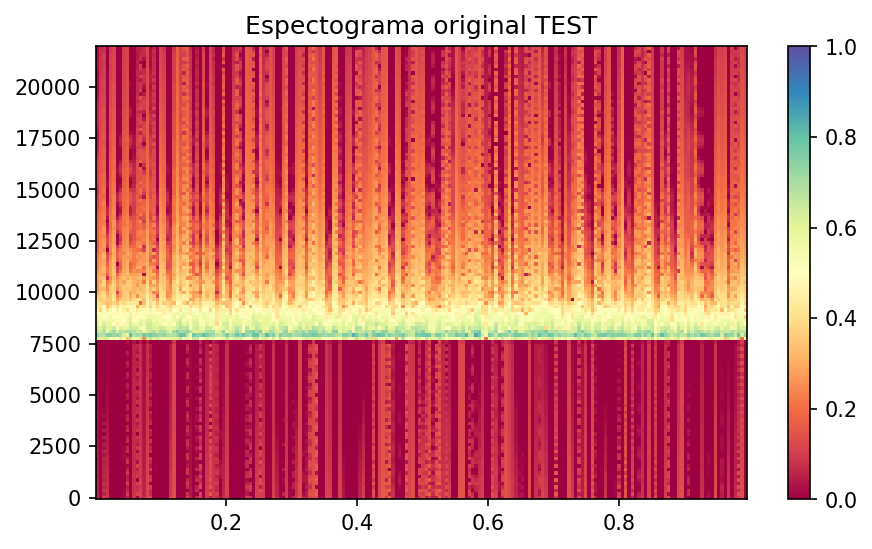

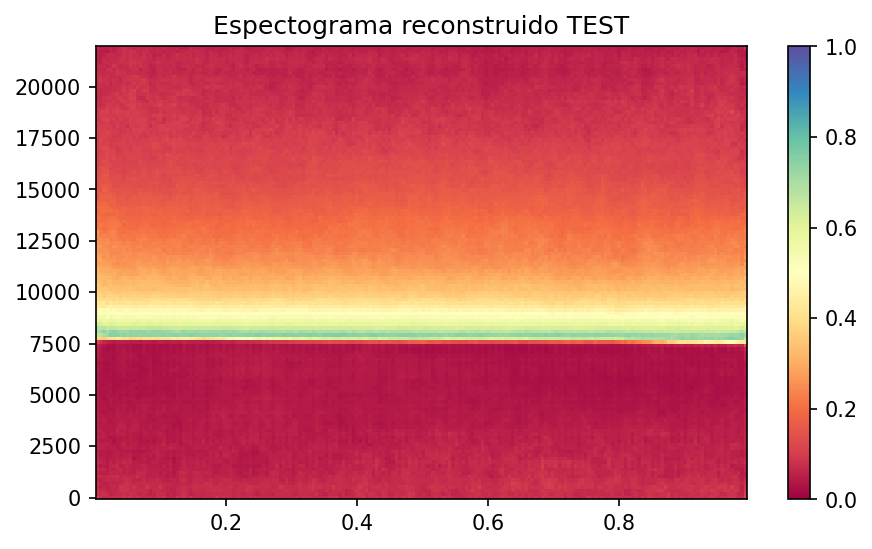

In [132]:
#GRAFICAR ESPECTOGRAMAS
#Se cargan los ejes temporales. Estos datos se pueden obtener a partir de la frecuencia de muestreo y el tiempo, pero se obtienen directos de memoria. 
# Se generaron al realizar los espectogramas-
from multiprocessing import Value
from matplotlib.colors import BoundaryNorm


tiempo=np.load('C:/Users/el_lu/Desktop/proyectospython/DATOS/frecuencia.npy')
frecuencia=np.load('C:/Users/el_lu/Desktop/proyectospython/DATOS/tiempo.npy')

#El tamaño de estos ejes se adecuada a la longitud de las imagenes.
tiempo1=tiempo[0:128]
frec1=frecuencia[0:196]

#La matriz que se debe pasar para el espectograma debe ser de 2 dimensiones.
original=imagen_original[:,:,0]     # Tendran la dimension (128,196)
reconstruida=imagen_salida[:,:,0]   # Tendran la dimension (128,196)

# Creando figura 
Fig1=plt.figure(figsize=(7,4),dpi=150)
#plt.subplot(1,2,1)
#plt.text(0.8,26000,"ESPECTOGRAMAS BALLENA FRANCA", fontsize=12)
#plt.text(0.4,-4000,"(MSE="+str(MSE)+"); SSIM="+str(SSIM)+"); N="+str(len(x_train[:,1,1]))+")",fontsize=10)
plt.title("Espectograma original TEST")
Pxx_original=plt.pcolormesh(frec1, tiempo1, original, vmin=0, vmax=1,cmap='Spectral')
plt.colorbar()
#plt.subplot(1,2,2)
Fig1=plt.figure(figsize=(7,4),dpi=150)
plt.title("Espectograma reconstruido TEST")
Pxx_reconstruida=plt.pcolormesh(frec1, tiempo1, reconstruida,  vmin=0, vmax=1,cmap='Spectral')

plt.colorbar()

print("(MSE="+str(MSE)+"); SSIM="+str(SSIM)+"); N="+str(len(x_train[:,1,1]))+")")

### EVALUACIÓN DE LA IMAGEN FINAL CON DATOS DE TRAIN

##### Adecuación de la imagen original con datos de TRAIN

In [72]:
#-------Se carga 1 SOLA imagen del conjunto de TRAIN y se la adecua para ingresar a la funcion que cuantifica el error.---

#Cargamos las imagenes a comparar. Esto carga UNA SOLA IMAGEN  del conjunto de TEST.

N=56                                               # Posición dentro del set de imagenes, de la imagen que quiere comparar
imagen_original_train=x_train[N,:]                   #N° imagen comparada: dimensión de los datos de entrada de test es: (128, 196, 1) y tipo array.
imagen_original= np.float32(imagen_original_train)  #Paso a float 32 para evitar un  warning que sale al comparar la imagen original con la reconstruida.


#Esta parte haría falta si se quiere observar la salida para una iagen en particular
# Esta función me devuelve una tupla que contiene en: -[0] un tensor de todas las imagenes reconstruídas y en [1] la/las imagen/es codigo en el espacio latente.
    #La dimensión del dato de entrada debe ser (n,x,y,1), siendo n la cantidad de imagenes que se generan a la salida.
    #Para que sólo ingrese una imagen y se genere un sólo código, se debe agregar una cuarta dimension.

#imagen_original_4dim_tensor=tf.expand_dims(imagen_original, axis=0) #Esta función me devuelve un tensor, asique se debe pasar a array.
#imagen_original_4dim = tf.Session().run(imagen_original_4dim_tensor)

##### Cálculo de los errores con imagenes de TRAIN

In [73]:
# print('En la posición RESULTADO[0] se encuentra el tensor de imagenes, cuya dimensión es:',np.shape(tratadas_todas[0]))
# print('En la posición RESULTADO[1] se encuentra el tensor del espacio latente, cuya dimensión es:',np.shape(tratadas_todas[1]))
#RESULTADO=autoencoder_CNN.reconstruct(imagen_original_4dim)  

RESULTADO=autoencoder_CNN.reconstruct(x_train)  

aux=RESULTADO[0]   #matriz de imagenes de salida (n,128, 196, 1) para los datos de test
imagen_salida=aux[N,:]  #Reconstrucción de la primer imagen. La dimensión  es: (128, 196, 1)

# # Calcula el error cuadrático medio entre dos imagenes
MSE=skimage.measure.compare_mse(imagen_original,imagen_salida)
print('El error cuadrático medio es:',MSE)

# # #Calcula el índice SSIM entre dos imagenes
SSIM=skimage.measure.compare_ssim(imagen_original,imagen_salida,multichannel=True)
print('El índice SSIM es:',SSIM)

El error cuadrático medio es: 0.0033295589852884383
El índice SSIM es: 0.6157614033613836


c:\ProgramData\Anaconda3\envs\env_tensorflow2-3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.
  # This is added back by InteractiveShellApp.init_path()
c:\ProgramData\Anaconda3\envs\env_tensorflow2-3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  from ipykernel import kernelapp as app


##### ESPECTOGRAMAS  de comparación con datos de TRAIN

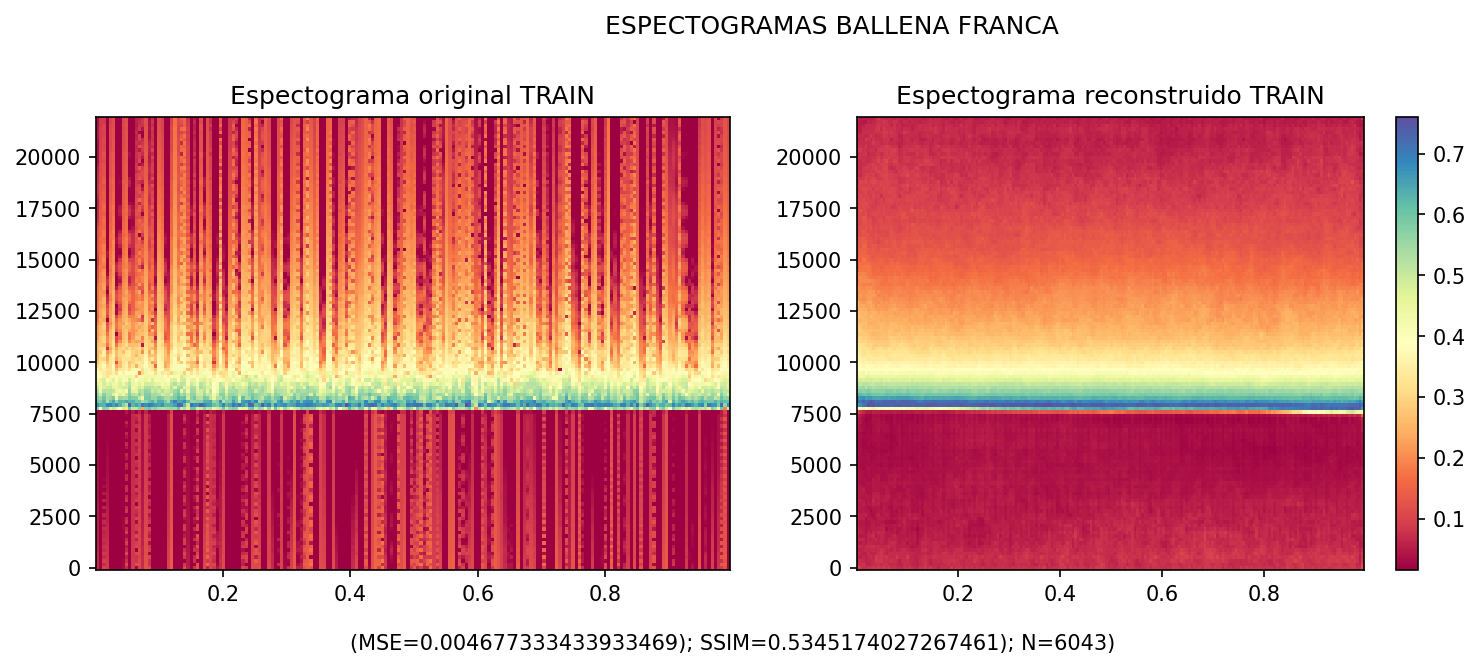

In [126]:
#GRAFICAR ESPECTOGRAMAS
#Se cargan los ejes temporales. Estos datos se pueden obtener a partir de la frecuencia de muestreo y el tiempo, pero se obtienen directos de memoria. 
# Se generaron al realizar los espectogramas-
#tiempo=np.load('C:/Users/Celeste/Desktop/Python_proyects/Datos/frecuencia.npy')   #-------en windows
tiempo=np.load('C:/Users/el_lu/Desktop/proyectospython/DATOS/frecuencia.npy')     #-------en MINT

#frecuencia=np.load('C:/Users/Celeste/Desktop/Python_proyects/Datos/tiempo.npy')  #-------en windows
frecuencia=np.load('C:/Users/el_lu/Desktop/proyectospython/DATOS/tiempo.npy')  #-------en MINT

#El tamaño de estos ejes se adecuada a la longitud de las imagenes.
tiempo1=tiempo[0:128]
frec1=frecuencia[0:196]

#La matriz que se debe pasar para el espectograma debe ser de 2 dimensiones.
original=imagen_original[:,:,0]     # Tendran la dimension (128,196)
reconstruida=imagen_salida[:,:,0]   # Tendran la dimension (128,196)


# Creando figura 
plt.figure(figsize=(12,4),dpi=150)
#plt.subplot(1,2,1)
plt.text(0.8,26000,"ESPECTOGRAMAS BALLENA FRANCA ", fontsize=12)
plt.text(0.4,-4000,"(MSE="+str(MSE)+"); SSIM="+str(SSIM)+"); N="+str(len(x_train[:,1,1]))+")",fontsize=10)
plt.title("Espectograma original TRAIN")
Pxx_original=plt.pcolormesh(frec1, tiempo1, original, cmap='Spectral')
plt.colorbar()
#plt.subplot(1,2,2)
plt.title("Espectograma reconstruido TRAIN")
Pxx_reconstruida=plt.pcolormesh(frec1, tiempo1, reconstruida, cmap='Spectral')
plt.colorbar()

### GENERAR IMAGEN FICTICIA
En este punto se pretende obtener una imagen ficticia a partir del código generado por el autoencoder. En realidad, con este modelo se genera un código para cada imagen entrenada. Se debería escoger alguno al azar y generar una muestra.


In [77]:
#El código generado posee tantas subcódigos como datos fueron entrenados en el autoecoder y se obtendra una imagen similar.
# Los subcodigos son discretos, por ende debo enviarle un código en particular. 
#La elección del código ingresado podría hacerse de forma aleatoria.
import random

codigo=RESULTADO[1]
print(np.shape(codigo))
M=random.randint(0, len(codigo[:,0]))
print(M)
codigo_unico=codigo[M,:]
print(codigo_unico)
print(np.shape(codigo_unico),type(codigo_unico))

codigo_unico_tensor=tf.expand_dims(codigo_unico, axis=0) #Esta función me devuelve un tensor, asique se debe pasar a array.
codigo_unico_final= tf.compat.v1.Session().run(codigo_unico_tensor)

Imagen_final = autoencoder_CNN.Decoder.predict(codigo_unico_final)
#print(type(Imagen_final),np.shape(Imagen_final))

# tiempo1=tiempo[0:128]
# frec1=frecuencia[0:196]
# aux2=Imagen_final[0,:]
# aux3=aux2[:,:,0]
# print(np.shape(aux3))

# Pxx_original=plt.pcolormesh(frec1, tiempo1, aux3, cmap='Spectral')

(280, 2)
218
[-0.00705029 -0.00156867]
(2,) <class 'numpy.ndarray'>
[-0.00705029 -0.00156867]
(2,) <class 'numpy.ndarray'>


#### DEFINICION DEL AUTOENCODER_CNN_SSIM

In [36]:
#DEFINICIÓN DE LA CLASE AUTOENCODER. 

class AutoEncoder_SSIM:

    def __init__(self,
                 input_shape,   # Dimensión de los datos de entrada. En este caso, espectogramas 2D.
                 conv_filters,  # Cantidad de filtros de convolución de cada capa.
                 conv_kernels,  # Dimensions de los filtros convolucionales. De por sí, estos filtros se piensan en 
                                # 2D porque la entrada es 2D y se definirá así. En este caso, las dimensiones de las 
                                # filas=columnas.
                 conv_strides,  # El corrimiento en la convolución del filtro con la entrada.
                 latent_space_dim): #Dimensión del espacio latente utilizado como  bottleneck entre encoder and decoder
   
        self.input_shape = input_shape # Cada  entradas individualmente tendrá la dimensión [196,128,1]  
        self.conv_filters = conv_filters # [2, 4, 8] 
        self.conv_kernels = conv_kernels # [3, 5, 3] ==> (3x3x1,5x5x1,3x3x1)
        self.conv_strides = conv_strides # [1, 2, 2]
        self.latent_space_dim = latent_space_dim #
        self.Encoder = None
        self.Decoder = None
        self.Model = None
        self._model_input = None
        self._num_conv_layers = len(conv_filters) # Número de capas convolucionales en el modelo.
        self._shape_before_bottleneck = None
      
        
        self._build() #Método para crear el Modelo

  #Definición del Método para crear los modelos
    def _build(self):
        self._build_encoder() #Crear  modelo de codificador
        self._build_decoder()  #Crear  modelo de decodificador
        self._build_autoencoder() #crear modelo unificado

  #----------------------------------------------------------------------------------------
  #                   ENCODER
  #---------------------------------------------------------------------------------------
  #Se define la construcción del codificador
    def _build_encoder(self):
        encoder_input = self._add_encoder_input() #Add input layer
        conv_layers = self._add_conv_layers(encoder_input) #Add all conv layers
        bottleneck = self._add_bottleneck(conv_layers) #Agrega el cuello de botella
        self._model_input = encoder_input 
        self.Encoder = Model(encoder_input, bottleneck, name='Encoder_v1') # El modelo se crea con la entrada, la salida bottleneck

    def _add_encoder_input(self):
        return Input(
            shape = self.input_shape,
            name = "Encoder_Input_layer"
            )

    def _add_conv_layers(self, temp_model):
        #Creation of all convolutional layers in the model.#
        aux = temp_model
        #Add layer to layer to the model
        for layer in range(self._num_conv_layers):
            aux = self._add_conv_layer(layer,aux)
        return aux

    def _add_conv_layer(self, layer, temp_model):
    #Agregue capass convolucionales al modelo (temp_model). Cada capa convolucional consiste en:
    #- Conv2D: convolución con filtros 2D.
    #- ReLU : función de activación aplicada al resultado de la convolución.
    #- BatchNromalzation : Esta operación se agrega como capa de Subsampling o Pooling (capa de reducción de parámetros). Esta operación acelera el proceso de entrenamiento.
        # Cada capa de una red neuronal tiene entradas con una distribución correspondiente,que se ve afectada durante el proceso de entrenamiento por 
        # la aleatoriedad en la inicialización de parámetros y la aleatoriedad en los datos de entrada. 
        # El efecto de estas fuentes de aleatoriedad en la distribución de las entradas  produce cambios en las medias y las varianzas de las entradas 
        # a las capas internas durante el entrenamiento. 
        # Durante la etapa de entrenamiento de las redes, a medida que cambian los parámetros de las capas anteriores, la distribución de entradas a la capa cambia,
        # de modo que la capa actual necesita reajustarse constantemente a las nuevas distribuciones. Este problema aumenta en redes profundas, 
        # ya que los pequeños cambios en las capas ocultas menos profundas se amplificarán a medida que se propaguen dentro de la red.. 
        # Por lo tanto, se propone el método de normalización por lotes para reducir estos cambios no deseados para acelerar el entrenamiento y 
        # producir modelos más confiables.
        # La normalización por lotes parece tener un efecto de regularización, de modo que la red mejora sus propiedades de generalización.
        # También se ha observado que, con la norma por lotes, la red se vuelve más robusta a diferentes esquemas de inicialización y tasas de aprendizaje.
    #- El padding se ajusta para obtener a la salida de cada convoloción, las matrices adecuadas.
    
        conv_layer = Conv2D(
            filters=self.conv_filters[layer],
            kernel_size=self.conv_kernels[layer],
            strides=self.conv_strides[layer],
            padding="same", #Esta opción habilita para que se agrega padding de forma automática.
            name="encoder_conv_layer_"+str(layer)
            )
        temp_model = conv_layer(temp_model)
        temp_model = ReLU(name="encoder_ReLU_layer_"+str(layer))(temp_model)
        temp_model = BatchNormalization(name="encoder_BN_layer_"+str(layer))(temp_model)
        return temp_model
    
    def _add_bottleneck(self, temp_model):
    #- Se agrega una capa densa (totalmente conectada) al modelo, para obtener el espacio latente.
    #- Se debe agregar una capa Flatten para remodelar el tensor de salida de las capas convolucionales a un vector adecuado para una capa Densa.
    #- Se almacena información sobre la forma del modelo, antes de almacenar el espacio latente, para el proceso de duplicación mientras se construye el decoder. 
    #- Se guarda el modelo para poder replicar en el decoder.
        self._shape_before_bottleneck = K.int_shape(temp_model)[1:]
        temp_model = Flatten()(temp_model) #Se agrega una capa Flatten para obtener una matriz representativo. 
        temp_model = Dense(self.latent_space_dim, name="Encoder_output")(temp_model)
        return temp_model

  #------------------------------------------------------------------------------------------------------------------------------
  #                   DECODER
  #------------------------------------------------------------------------------------------------------------------------------
    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.Decoder = Model(decoder_input, decoder_output, name="Decoder_v1")

    def _add_decoder_input(self):
        return Input(
            shape = (self.latent_space_dim,),   #Acá va a así
            name = "Decoder_input_layer"
        )

    def _add_dense_layer(self, temp_model):
        dense_layer = Dense(
            np.prod(self._shape_before_bottleneck),
            name = "Decoder_dense_layer"
            )(temp_model)
        return dense_layer

    def _add_reshape_layer(self,temp_model):
        return Reshape(self._shape_before_bottleneck)(temp_model)

    def _add_conv_transpose_layers(self, temp_model):
        # Add all the transpose convolutional layers to the model"""
        for layer in reversed(range( 1, self._num_conv_layers)):
              temp_model = self._add_conv_transpose_layer(layer,temp_model)
        return temp_model

    def _add_conv_transpose_layer(self,layer,temp_model):
        #"Add a single transpose conv layer to the model """
        layer_num = self._num_conv_layers - layer
        conv_transpose_layer = Conv2DTranspose(
            filters = self.conv_filters[layer],
            kernel_size=self.conv_kernels[layer],
            strides=self.conv_strides[layer],
            padding="same",
            name="decoder_conv_transpose_layer_"+str(layer) #Las F string son válidas  a partir de Python 3.6
            )
        temp_model = conv_transpose_layer(temp_model)
        temp_model = ReLU(name ="decoder_ReLU_transpose_layer_"+str(layer))(temp_model)
        temp_model = BatchNormalization(name = "decoder_BN_transpose_layer_"+str(layer))(temp_model)
        return temp_model

    def _add_decoder_output(self, temp_model):
        conv_transpose_layer = Conv2DTranspose(
            filters=1,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name="decoder_conv_transpose_layer_"+str(self._num_conv_layers)
            )
        temp_model = conv_transpose_layer(temp_model)
        output_layer = Activation("sigmoid", name="sigmoid_layer")(temp_model)
        return output_layer

  #----------------------------------------------
  #                   AUTOENCODER
  #----------------------------------------------
    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.Decoder(self.Encoder(model_input))
        self.Model = Model(model_input, model_output, name="AutoEncoder_CNN_SSIM")

  #----------------------------------------------------------------------------------------------------------------------
  #            COMPILATION AND TRAINING
  #----------------------------------------------------------------------------------------------------------------------
    # Al compilar, debemos especificar algunas propiedades adicionales necesarias para la formación de la red. 
    # Entrenar una red significa encontrar el mejor conjunto de pesos para que la red haga lo que debe hacer. 
    # Debemos especificar la función de pérdida a utilizar para evaluar un conjunto de pesos, el optimizador utilizado para buscar a través de diferentes pesos para la red. 
    # y si quisiecemos podríamos agregar cualquier métrica opcional que nos gustaría recopilar y reportar durante el entrenamiento.
    # Para el entrenamiento se utiliza el error cuadrado medio como función de pérdida y un tipo de optimizador denominada Adam.
    # Aam es un algoritmo de optimización de reemplazo para el descenso de gradiente estocástico para entrenar modelos de aprendizaje profundo.
    def error_SSIM(y_true, y_pred):
        error=1-skimage.measure.compare_ssim(y_pred,y_true)
        return  error

    def compile(self, learning_rate=0.0001):
        optimizer = Adam(lr=learning_rate)
        mse_loss = self.error_SSIM
        self.Model.compile(optimizer=optimizer, loss=mse_loss)
    
    #Hemos definido nuestro modelo y lo hemos compilado listo para un cálculo eficiente. Ahora es el momento de ejecutar el modelo sobre algunos datos. 
    #Podemos entrenar o ajustar nuestro modelo a los datos cargados llamando a la función fit() en el modelo.
    # El proceso de entrenamiento se ejecutará para un número fijo de iteraciones denominado epochs o épocas. 
    # También podemos establecer el número de instancias que se evalúan antes de que se realice una actualización de peso en la red llamada batch_size 
    # Para este problema utilizaremos un pequeño número de epochs (150) y un batch_size relativamente pequeño (10). 
    # Estos pueden ser elegidos experimentalmente por ensayo y error.
    #Esta función me devuelve un atributo de History. Si, en vez de utilizar para valiadción un porcentaje de los datos,
    #quisiera utilizar datos, entonces, debería cambiar porcentaje_valiacion por datos_validation= (x_test,x_test). Es decir que debno poner los datos
    #de test y el target.
    def train(self, x_train, batch_size, num_epochs,porcentaje_validacion):
        History = self.Model.fit(x_train,
                                x_train,
                                batch_size=batch_size,
                                epochs=num_epochs,
                                validation_split=porcentaje_validacion, #Indica el porcentaje de datos de train que se usarán para validación
                                shuffle=True)
        return History

  #----------------------------------------------
  #                   EVALUACIÓN DEL MODELO  
  #----------------------------------------------   
    #Esta función me devuelve Devuelve el valor de pérdida y los valores de métricas del modelo en modo de prueba.
    def evaluation(self,x_test):  
        evaluacion=self.Model.evaluate(
               x=x_test,
               y=x_test,
               verbose=1
               )
        return evaluacion

  #----------------------------------------------
  #                   STRUCTURE SUMMARY
  #----------------------------------------------

    def summary(self):
        self.Encoder.summary()
        self.Decoder.summary()
        self.Model.summary()

  #----------------------------------------------
  #                  GUARDAR EL MODELO
  #----------------------------------------------
    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
            parameters = [
              self.input_shape,
              self.conv_filters,
              self.conv_kernels,
              self.conv_strides,
              self.latent_space_dim
              ]
            save_path = os.path.join(save_folder, "parameters.pkl")
            with open(save_path, "wb") as f:
                pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5py")  #En versiones posteriores, la extensión podría ser .h5
        self.Model.save_weights(save_path)

  #----------------------------------------------
  #                  CARGAR EL MODELO
  #----------------------------------------------
    def load_weights(self, weights_path):
        self.Model.load_weights(weights_path)

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = AutoEncoder(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5py") #En versiones posteriores, la extensión podría ser .h5
        autoencoder.load_weights(weights_path)
        return autoencoder

  #----------------------------------------------
  #                   PREDICTION
  #----------------------------------------------
  #Reconstrucción de las  imagenenes de entrada
  #Esta función devuelve un tensor de 2 dimensiones:
  # - En la dimension 1 recostruirá una matriz de espectrograma, a partir de una matriz (dato) a la entrada.
  #     La forma de los datos de entrada será un tensor de 4 dimensiones. La salida será también un tensor de 4 dimensiones.
  #     Es decir, si se ingresa con n cantidad de imagenes (n,x,y,1), la salida será un tensor (n,x1,y1,1)
  # - En la dimensión 2, devuelve el tensor de espacio latente. En este tipo de convolucionales, el espacio latente es discreto, 
  #     por lo tanto devolverá un vector por cada imagne ingresada. 

  #Se utiliza con algún dato de test para corroborar la similitud.Luego se podría calcular algún tipo de error.
  #el la posición 1 del tensor se encuentra el espacio latente.
    def reconstruct(self, images):
        latent_representations = self.Encoder.predict(images)
        reconstructed_images = self.Decoder.predict(latent_representations)
        return reconstructed_images, latent_representations
 

#### ARQUITECTURA ESPECIFICA DEL AUTOENCODER_CNN_SSIM

In [37]:
autoencoder2 = AutoEncoder_SSIM(
            input_shape=(input_shape[0],input_shape[1], 1), #Tamaño de los datos x_train_norm. 
            conv_filters=(32, 64, 64, 64),  #Cantidad de filtros de convolusión de cada capa.
            conv_kernels=(3, 3, 3, 3),   # Dimension de los filtros convolucionales. En este caso, todos serán iguales.
            conv_strides=(1, 2, 2, 1),  #Corrimiento realizado en la convolución, entre el filtro y la entrada, por capa.
            latent_space_dim = 2 #Dimensión del espacio latente 
            )
autoencoder2.summary()  #muestra resumen de arquitectura

Model: "Encoder_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_Input_layer (InputLa [(None, 128, 196, 1)]     0         
_________________________________________________________________
encoder_conv_layer_0 (Conv2D (None, 128, 196, 32)      320       
_________________________________________________________________
encoder_ReLU_layer_0 (ReLU)  (None, 128, 196, 32)      0         
_________________________________________________________________
encoder_BN_layer_0 (BatchNor (None, 128, 196, 32)      128       
_________________________________________________________________
encoder_conv_layer_1 (Conv2D (None, 64, 98, 64)        18496     
_________________________________________________________________
encoder_ReLU_layer_1 (ReLU)  (None, 64, 98, 64)        0         
_________________________________________________________________
encoder_BN_layer_1 (BatchNor (None, 64, 98, 64)        2

#### ENTRENAMIENTO

In [38]:
#DATOS NECESARIOS PARA EL ENTRENAMIENTO
LEARNING_RATE = 0.0005
BATCH_SIZE = 100
EPOCHS = 1
porcentaje_validacion=0.2 #porcentaje de datos de entrenamiento destinado a la validación

#COMPILACIÓN Y ENTRENAMIENTO
autoencoder2.compile(LEARNING_RATE)

#ENTRENAMIENTO
History=autoencoder2.train(x_train,BATCH_SIZE,EPOCHS,porcentaje_validacion)

TypeError: in user code:


    TypeError: tf__error_SSIM() takes 2 positional arguments but 3 were given


## AUTOENCODER (VAE)

La primera mejora que se puede hacer a la versión anterior del AutoEncoder es utilizar un enfoque de AutoEncoder variacional.

El principal cambio con respecto al AutoEncoder estándar es que VAE utiliza el conjunto de TRIAN para desarrollar una distribución multidimensional que es continua en el espacio latente. La asignación a puntos únicos en el espacio latente, que hace CNN dificulta la generación de nuevas salidas cohesivas cuando el espacio latente cuando la entrada está relativamente lejos de los puntos conocidos pertenecientes al conjunto de TRAIN.

In [133]:
tf.compat.v1.disable_eager_execution()

### DEFINICIÓN DE ARQUITECTURA

In [152]:
class VAE:
  """
  The present class refers to a Deep CNN Variational AutoEncoder architecture
  where the encoder and the decoder components are mirrored.
  """
  def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim):
    self.input_shape = input_shape # [28, 28, 1]
    self.conv_filters = conv_filters # [2, 4, 8]
    self.conv_kernels = conv_kernels # [3, 5, 3]
    self.conv_strides = conv_strides # [1, 2, 2]
    self.latent_space_dim = latent_space_dim # 2
    self.reconstruction_loss_weight = 1000
    self.Encoder = None
    self.Decoder = None
    self.Model = None
    self._model_input = None
    self._num_conv_layers = len(conv_filters) #Number of convolutional layers in the Model
    self._shape_before_bottleneck = None

    self._build()
  
  def _build(self):
    self._build_encoder() #Method to create the Encoder model
    self._build_decoder()
    self._build_autoencoder() 

  #----------------------------------------------
  #                   ENCODER
  #----------------------------------------------
  def _build_encoder(self):
    encoder_input = self._add_encoder_input() #Add input layer
    conv_layers = self._add_conv_layers(encoder_input) #Add all conv layers
    bottleneck = self._add_bottleneck(conv_layers) 
    self._model_input = encoder_input 
    self.Encoder = Model(encoder_input, bottleneck, name='Encoder_VAE')

  def _add_encoder_input(self):
    return Input(
        shape = self.input_shape,
        name = "Encoder_Input_layer"
    )

  def _add_conv_layers(self, temp_model):
    """Creation of all convolutional layers in the model."""
    aux = temp_model

    #Add layer to layer to the model
    for layer in range(self._num_conv_layers):
      aux = self._add_conv_layer(layer,aux)
      
    return aux

  def _add_conv_layer(self, layer, temp_model):
    """
    Add a single convolutional layer to the model (temp_model)
    Each convolutional layer consist on:
    Conv2D: convolution with filters
    ReLU : activation function applied to the result of the convolution
    BatchNromalzation : Operation included to speed up the training process

    :param: layer: the actual layer index in the model building process
    :param: temp_model: the in-developing model to which the conv layer will be added 
    """
    conv_layer = Conv2D(
        filters=self.conv_filters[layer],
        kernel_size=self.conv_kernels[layer],
        strides=self.conv_strides[layer],
        padding="same",
        name=f"encoder_conv_layer_{layer}"
        )
    temp_model = conv_layer(temp_model)
    temp_model = ReLU(name=f"encoder_ReLU_layer_{layer}")(temp_model)
    temp_model = BatchNormalization(name=f"encoder_BN_layer_{layer}")(temp_model)
    return temp_model
    
  #ESPACIO LATENTE  
    """
    Se agrega una capa densa (totalmente conectada) al modelo para obtener el espacio latente.
    Esta capa (Flatten) remodela el tensor de salida de las capas convolucionales a un vector adecuado.
    """
  def _add_bottleneck(self, temp_model):
    self._shape_before_bottleneck = K.int_shape(temp_model)[1:]   #Información sobre la forma del modelo antes de almacenar el espacio latente. Sirve para el proceso de duplicación al  construir el Decodificador.
    temp_model = Flatten()(temp_model)

    #El espacio latente está envuelto por una distribución normal. La distribución normal está completamente definida por su valor medio y su desviación
    self.mu = Dense(self.latent_space_dim, name = "mu_latent_space")(temp_model)
    self.log_variance = Dense(self.latent_space_dim, name = "log_variance_latent_space")(temp_model)
    
    #Definición de la distribución normal. Esta sera la funcion de transformacion
    def map_to_normal_distribution(args):  
      mu, log_variance = args   #me devuelve la media y el logaritmo de la varianza
      base_gaussian = K.random_normal(
        shape = K.shape(self.mu),
        mean = 0.,
        stddev = 1.
      )
      point = mu + K.exp(log_variance/2) * base_gaussian # la desviacion standar es la raiz cuadrada de la varianza
      return point

    #Las capas Lambda se utilizan para implementar capas con una función artesanal.
    # En este caso, la función seguirá la distribución normal parametrizada
    # cuyos parámetros deben ser entrenados

    temp_model = Lambda(
        map_to_normal_distribution,
        name = "Encoder_output")([self.mu,self.log_variance])

    return temp_model

  #----------------------------------------------
  #                   DECODER
  #----------------------------------------------
  def _build_decoder(self):
    decoder_input = self._add_decoder_input()
    dense_layer = self._add_dense_layer(decoder_input)
    reshape_layer = self._add_reshape_layer(dense_layer)
    conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
    decoder_output = self._add_decoder_output(conv_transpose_layers)
    self.Decoder = Model(decoder_input, decoder_output, name="Decoder_VAE")

  def _add_decoder_input(self):
    return Input(
        shape = (self.latent_space_dim,),
        name = "Decoder_input_layer"
    )

  def _add_dense_layer(self, temp_model):
    dense_layer = Dense(
        np.prod(self._shape_before_bottleneck),
        name = "Decoder_dense_layer"
    )(temp_model)
    return dense_layer

  def _add_reshape_layer(self,temp_model):
    return Reshape(self._shape_before_bottleneck)(temp_model)

  def _add_conv_transpose_layers(self, temp_model):
    """ Add all the transpose convolutional layers to the model"""
    for layer in reversed(range( 1, self._num_conv_layers)):
      temp_model = self._add_conv_transpose_layer(layer,temp_model)

    return temp_model

  def _add_conv_transpose_layer(self,layer,temp_model):
    """Add a single transpose conv layer to the model """

    layer_num = self._num_conv_layers - layer

    conv_transpose_layer = Conv2DTranspose(
        filters = self.conv_filters[layer],
        kernel_size=self.conv_kernels[layer],
        strides=self.conv_strides[layer],
        padding="same",
        name="decoder_conv_transpose_layer_"+str(layer)
        )
    
    temp_model = conv_transpose_layer(temp_model)
    temp_model = ReLU(name ="decoder_ReLU_transpose_layer_"+str(layer))(temp_model)
    temp_model = BatchNormalization(name = f"decoder_BN_transpose_layer_"+str(layer))(temp_model)

    return temp_model

  def _add_decoder_output(self, temp_model):

     conv_transpose_layer = Conv2DTranspose(
            filters=1,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name="decoder_conv_transpose_layer_"+str(self._num_conv_layers)
        )
     temp_model = conv_transpose_layer(temp_model)
     output_layer = Activation("sigmoid", name="sigmoid_layer")(temp_model)
    
     return output_layer

  #----------------------------------------------
  #                   AUTOENCODER
  #----------------------------------------------
  def _build_autoencoder(self):
    model_input = self._model_input
    model_output = self.Decoder(self.Encoder(model_input))
    self.Model = Model(model_input, model_output, name="Variational_AutoEncoder(VAE)")

  #----------------------------------------------
  #            COMPILATION AND TRAINING
  #----------------------------------------------
  def compile(self, loss_function = "MSE",learning_rate=0.0001):
        optimizer = Adam(learning_rate=learning_rate)
        self.Model.compile(optimizer=optimizer,
                              loss=self._calculate_combined_loss,
                              metrics=[self._calculate_reconstruction_loss, self._calculate_kl_loss] #Metrics are evaluated by the model during training and testing.
                              )
  
  def _calculate_combined_loss(self, y_target, y_predicted):
    """
    the reconstruction loss weight may be optimized during the training process or using some hyperparameter optimization method
    """
    reconstruction_loss = self._calculate_reconstruction_loss(y_target, y_predicted)
    kl_loss = self._calculate_kl_loss(y_target, y_predicted)
    combined_loss = self.reconstruction_loss_weight * reconstruction_loss + kl_loss
    return combined_loss

  def _calculate_reconstruction_loss(self, y_target, y_predicted):
    error = y_target - y_predicted
    reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])
    return reconstruction_loss

  def _calculate_kl_loss(self, y_target, y_predicted):
    """
    The main objetive of KL loss is to take the resulting multivariational distribution the closest possible to
    a standard normal distribution. It also improves the symmetry around the origin, which helps to avoid gaps in the
    latent space.
    """
    kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu) - K.exp(self.log_variance), axis=1)
    return kl_loss


  def train(self, x_train, batch_size, num_epochs,porcentaje_validacion):
        History= self.Model.fit(x_train,
                       x_train,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       validation_split=porcentaje_validacion,
                       shuffle=True)
        return History
  #----------------------------------------------
  #                   STRUCTURE SUMMARY
  #----------------------------------------------

  def summary(self):
      self.Encoder.summary()
      self.Decoder.summary()
      self.Model.summary()

  #----------------------------------------------
  #                   SAVE THE MODEL
  #----------------------------------------------
  def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

  def _create_folder_if_it_doesnt_exist(self, folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

  def _save_parameters(self, save_folder):
      parameters = [
          self.input_shape,
          self.conv_filters,
          self.conv_kernels,
          self.conv_strides,
          self.latent_space_dim
      ]
      save_path = os.path.join(save_folder, "parameters.pkl")
      with open(save_path, "wb") as f:
          pickle.dump(parameters, f)

  def _save_weights(self, save_folder):
      save_path = os.path.join(save_folder, "weights.h5py")
      self.Model.save_weights(save_path)

  #----------------------------------------------
  #                   LOAD THE MODEL
  #----------------------------------------------
  def load_weights(self, weights_path):
    self.Model.load_weights(weights_path)

  @classmethod
  def load(cls, save_folder="."):
    parameters_path = os.path.join(save_folder, "parameters.pkl")
    with open(parameters_path, "rb") as f:
        parameters = pickle.load(f)
    autoencoder = VAE(*parameters)
    weights_path = os.path.join(save_folder, "weights.h5py")
    autoencoder.load_weights(weights_path)
    return autoencoder

  #----------------------------------------------
  #                   PREDICTION
  #----------------------------------------------
  def reconstruct(self, images):
    latent_representations = self.Encoder.predict(images)
    reconstructed_images = self.Decoder.predict(latent_representations)
    return reconstructed_images, latent_representations

### ARQUITECTURA ESPECIFICA

In [33]:
autoencoder_VAE = VAE(
            input_shape=(input_shape[0],input_shape[1], 1), #Tamaño de los datos x_train_norm. 
            conv_filters=(32, 64, 64, 64),  #Cantidad de filtros de convolusión de cada capa.
            conv_kernels=(3, 3, 3, 3),   # Dimension de los filtros convolucionales. En este caso, todos serán iguales.
            conv_strides=(1, 2, 2, 1),  #Corrimiento realizado en la convolución, entre el filtro y la entrada, por capa.
            latent_space_dim = 3 #Dimensión del espacio latente 
            )
autoencoder_VAE.summary()  #muestra resumen de arquitectura

Model: "Encoder_VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Input_layer (InputLayer [(None, 128, 196, 1) 0                                            
__________________________________________________________________________________________________
encoder_conv_layer_0 (Conv2D)   (None, 128, 196, 32) 320         Encoder_Input_layer[0][0]        
__________________________________________________________________________________________________
encoder_ReLU_layer_0 (ReLU)     (None, 128, 196, 32) 0           encoder_conv_layer_0[0][0]       
__________________________________________________________________________________________________
encoder_BN_layer_0 (BatchNormal (None, 128, 196, 32) 128         encoder_ReLU_layer_0[0][0]       
________________________________________________________________________________________

### COMPILACIÓN Y ENTRENAMIENTO

In [159]:
#Este paso se agrega si se quiere seguir enetrenanado un modelo ya guardado
#Cargar el modelo
autoencoder_VAE = VAE.load("C:/Users/el_lu/Desktop/proyectospython/VAE3(48)")  #carga el modelo WINDOWS
#autoencoder2.summary()  #muestra el modelo
#autoencoder2 = AutoEncoder.load("/home/lac073/Escritorio/Programas de Python/Autoencoders/Modelo_CNN_simple")  #carga el modelo LINUX

In [203]:
#DATOS NECESARIOS PARA EL ENTRENAMIENTO
LEARNING_RATE = 0.0005
BATCH_SIZE = 20
EPOCHS = 300
porcentaje_validacion=0.2 #porcentaje de datos de entrenamiento destinado a la validación

#COMPILACIÓN Y ENTRENAMIENTO
autoencoder_VAE.compile(LEARNING_RATE)

#ENTRENAMIENTO
History=autoencoder_VAE.train(x_train,BATCH_SIZE,EPOCHS,porcentaje_validacion)

Train on 104 samples, validate on 27 samples
Epoch 1/300
104/104 [==============================] - 23s 220ms/sample - loss: 28.8246 - _calculate_reconstruction_loss: 0.0185 - _calculate_kl_loss: 10.3266 - val_loss: 36.1755 - val__calculate_reconstruction_loss: 0.0187 - val__calculate_kl_loss: 17.4777
Epoch 2/300
104/104 [==============================] - 21s 201ms/sample - loss: 139.8833 - _calculate_reconstruction_loss: 0.0248 - _calculate_kl_loss: 115.0843 - val_loss: 36.0498 - val__calculate_reconstruction_loss: 0.0262 - val__calculate_kl_loss: 9.8699
Epoch 3/300
104/104 [==============================] - 21s 201ms/sample - loss: 38.9425 - _calculate_reconstruction_loss: 0.0229 - _calculate_kl_loss: 16.0197 - val_loss: 35.4926 - val__calculate_reconstruction_loss: 0.0213 - val__calculate_kl_loss: 14.2295
Epoch 4/300
104/104 [==============================] - 20s 196ms/sample - loss: 37.1686 - _calculate_reconstruction_loss: 0.0216 - _calculate_kl_loss: 15.5313 - val_loss: 42.3635 -

### GUARDAR LOS VALORES DEL ERROR DE TRAIN Y VALIDACION

In [207]:

error_train=History.history["_calculate_reconstruction_loss"]
error_train_save=np.save('C:/Users/el_lu/Desktop/proyectospython/vectores_error/train_VAE3_franca_transfers_bachsize20.npy',error_train)

error_validation=History.history["val__calculate_reconstruction_loss"]
error_validation_save=np.save('C:/Users/el_lu/Desktop/proyectospython/vectores_error/val_VAE3_franca_transfers_bachsize20.npy',error_validation)



### GUARDAR MODELO

In [206]:
#Guarda el modelo
#autoencoder_CNN.save("C:/Users/Celeste/Desktop/Python_proyects/Autoencoders/modelo_CNN")  #especificar carpeta WINDOWS
#autoencoder_CNN.save("/home/lac073/Escritorio/Programas de Python/Autoencoders/Modelo_CNN_simple")  #especificar carpeta LINUX
autoencoder_VAE.save("C:/Users/el_lu/Desktop/proyectospython/VAE3_franca_transfer_bach_size20(300)")  #especificar carpeta LINUX

### CARGAR EL MODELO

In [153]:
#Cargar el modelo
#autoencoder2 = AutoEncoder.load("C:/Users/Celeste/Desktop/Python_proyects/Autoencoders/modelo_CNN")  #carga el modelo WINDOWS
autoencoder_VAE = VAE.load("C:/Users/el_lu/Desktop/proyectospython/Autoencoders/Arquitecturas/VAEs/VAE3(48)")  #carga el modelo WINDOWS lucas
#C:\Users\el_lu\Desktop\proyectospython\Autoencoders\Arquitecturas\VAEs\VAE3(48)
#autoencoder2 = AutoEncoder.load("/home/lac073/Escritorio/Programas de Python/Autoencoders/Modelo_CNN_simple")  #carga el modelo LINUX 
autoencoder_VAE.summary()  #muestra el modelo


Model: "Encoder_VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Input_layer (InputLayer [(None, 128, 196, 1) 0                                            
__________________________________________________________________________________________________
encoder_conv_layer_0 (Conv2D)   (None, 128, 196, 32) 320         Encoder_Input_layer[0][0]        
__________________________________________________________________________________________________
encoder_ReLU_layer_0 (ReLU)     (None, 128, 196, 32) 0           encoder_conv_layer_0[0][0]       
__________________________________________________________________________________________________
encoder_BN_layer_0 (BatchNormal (None, 128, 196, 32) 128         encoder_ReLU_layer_0[0][0]       
________________________________________________________________________________________

### EVALUACIÓN DEL MODELO

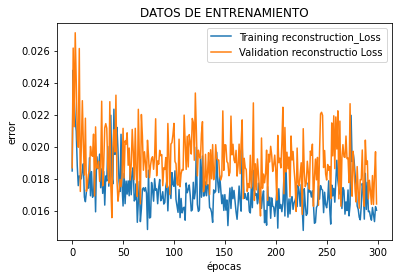

In [204]:
#En esta etapa se utilizarán los datos de validación para evaluar el entrenamiento. Los datos de validación son un porcentaje 
# de los datos de entrenamiento destinados a seguir la evolución del entrenamiento. Estos datos no participan del entrenamiento.
# Se generan gráficos que sirven para evaluar el entrenamiento: overfiting

fig = plt.figure()
plt.title("DATOS DE ENTRENAMIENTO")
plt.ylabel('error')
plt.xlabel('épocas')
plt.plot(History.history["_calculate_reconstruction_loss"], label="Training reconstruction_Loss")
plt.plot(History.history["val__calculate_reconstruction_loss"], label="Validation reconstructio Loss")
plt.legend()

### EVALUACIÓN DE LA IMAGEN FINAL

#### EVALUACION CON IMAGEN DE TEST

El error cuadrático medio es: 0.009771441351970401
El índice SSIM es: 0.4443687445331454


c:\ProgramData\Anaconda3\envs\env_tensorflow2-3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.
c:\ProgramData\Anaconda3\envs\env_tensorflow2-3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


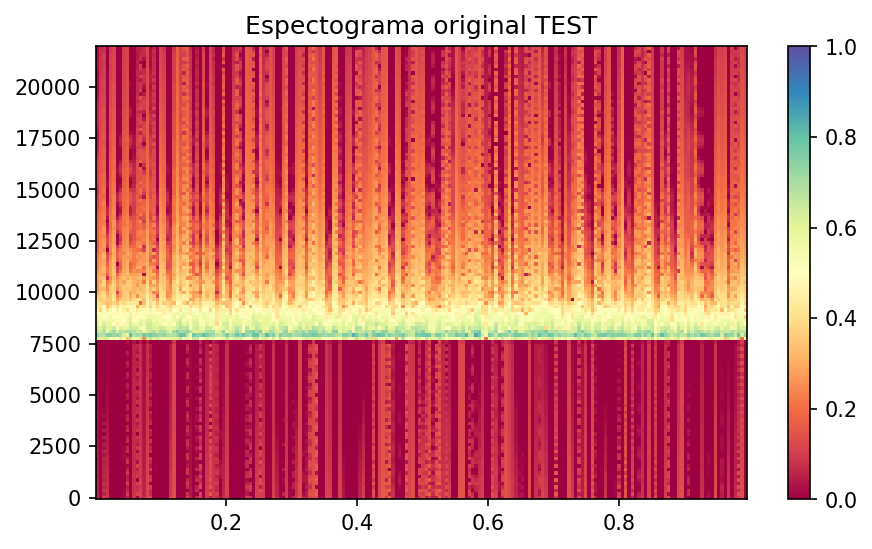

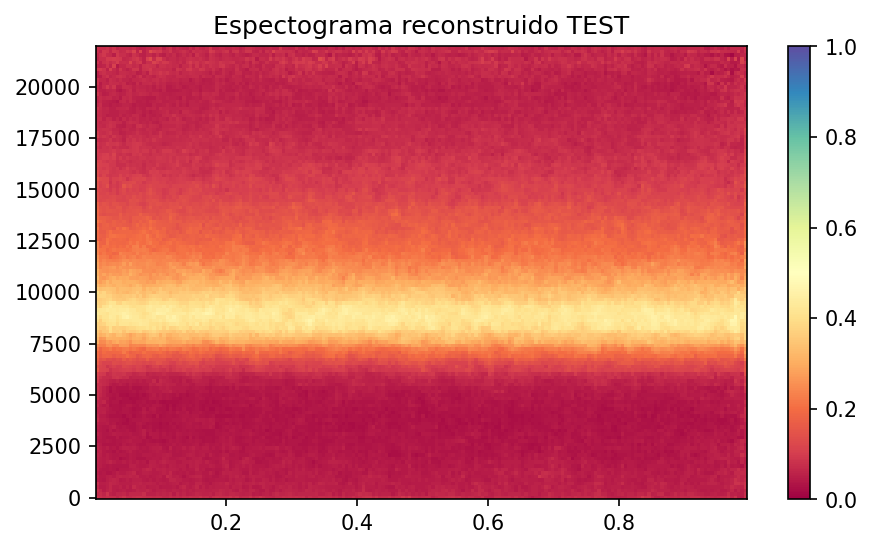

In [138]:
###---------------------------------------------------------------------------------------
#                              ADECUACIÓN DE LA IMAGEN DE TEST A COMPARAR
###---------------------------------------------------------------------------------------
#-------Se carga 1 SOLA imagen del conjunto de TEST y se la adecua para ingresar a la funcion que cuantifica el error.---
#Cargamos las imagenes a comparar. Esto carga UNA SOLA IMAGEN  del conjunto de TEST.
N=40                                        # Posición dentro del set de imagenes, de la imagen que quiere comparar
imagen_original_test=x_test[N,:]                   #N° imagen comparada: dimensión de los datos de entrada de test es: (128, 196, 1) y tipo array.
imagen_original= np.float32(imagen_original_test)  #Paso a float 32 para evitar un  warning que sale al comparar la imagen original con la reconstruida.

#Esta función me devuelve una tupla que contiene en: -[0] un tensor de todas las imagenes reconstruídas y en [1] la/las imagen/es codigo en el espacio latente.
    #La dimensión del dato de entrada debe ser (n,x,y,1), siendo n la cantidad de imagenes que se generan a la salida.
    #Para que sólo ingrese una imagen y se genere un sólo código, se debe agregar una cuarta dimension.
#imagen_original_4dim_tensor=tf.expand_dims(imagen_original, axis=0) #Esta función me devuelve un tensor, asique se debe pasar a array.
#imagen_original_4dim = tf.Session().run(imagen_original_4dim_tensor)

###---------------------------------------------------------------------------------------
#                              CÀLCULO DE ERRORES
###---------------------------------------------------------------------------------------
# print('En la posición RESULTADO[0] se encuentra el tensor de imagenes, cuya dimensión es:',np.shape(tratadas_todas[0]))
# print('En la posición RESULTADO[1] se encuentra el tensor del espacio latente, cuya dimensión es:',np.shape(tratadas_todas[1]))
#RESULTADO=autoencoder_CNN.reconstruct(imagen_original_4dim)  

RESULTADO=autoencoder_VAE.reconstruct(x_test)  ### Resultados de ingresar con todo el conjunto de datos de test al modelo entrenado.

aux=RESULTADO[0]   #matriz de imagenes de salida (n,128, 196, 1) para los datos de test
imagen_salida=aux[N,:]  #Reconstrucción de la primer imagen. La dimensión  es: (128, 196, 1)

# # Calcula el error cuadrático medio entre dos imagenes
MSE=skimage.measure.compare_mse(imagen_original,imagen_salida)
print('El error cuadrático medio es:',MSE)

# # #Calcula el índice SSIM entre dos imagenes
SSIM=skimage.measure.compare_ssim(imagen_original,imagen_salida,multichannel=True)
print('El índice SSIM es:',SSIM)

###---------------------------------------------------------------------------------------
#                             #GRAFICAR ESPECTOGRAMAS
###---------------------------------------------------------------------------------------
#Se cargan los ejes temporales. Estos datos se pueden obtener a partir de la frecuencia de muestreo y el tiempo, pero se obtienen directos de memoria. 
# Se generaron al realizar los espectogramas-
tiempo=np.load('C:/Users/el_lu/Desktop/proyectospython/DATOS/frecuencia.npy') # En Mint
frecuencia=np.load('C:/Users/el_lu/Desktop/proyectospython/DATOS/tiempo.npy')

#El tamaño de estos ejes se adecuada a la longitud de las imagenes.
tiempo1=tiempo[0:128]
frec1=frecuencia[0:196]

#La matriz que se debe pasar para el espectograma debe ser de 2 dimensiones.
original=imagen_original[:,:,0]     # Tendran la dimension (128,196)
reconstruida=imagen_salida[:,:,0]   # Tendran la dimension (128,196)

# Creando figura 
plt.figure(figsize=(7,4),dpi=150)
#plt.subplot(1,2,1)
#plt.text(0.8,26000,"ESPECTOGRAMAS BALLENAS BARBADAS", fontsize=12)
#plt.text(0.4,-4000,"(MSE="+str(MSE)+"); SSIM="+str(SSIM)+"); N="+str(len(x_train[:,1,1]))+")",fontsize=10)
plt.title("Espectograma original TEST")
Pxx_original=plt.pcolormesh(frec1, tiempo1, original,  vmin=0, vmax=1, cmap='Spectral')
plt.colorbar()
plt.figure(figsize=(7,4),dpi=150)#
plt.title("Espectograma reconstruido TEST")
Pxx_reconstruida=plt.pcolormesh(frec1, tiempo1, reconstruida, vmin=0, vmax=1,  cmap='Spectral')
plt.colorbar()

#### EVALUACION CON IMAGEN DE TRAIN

c:\ProgramData\Anaconda3\envs\env_tensorflow2-3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.
c:\ProgramData\Anaconda3\envs\env_tensorflow2-3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


El error cuadrático medio es: 0.021987708847978127
El índice SSIM es: 0.37511980283935553


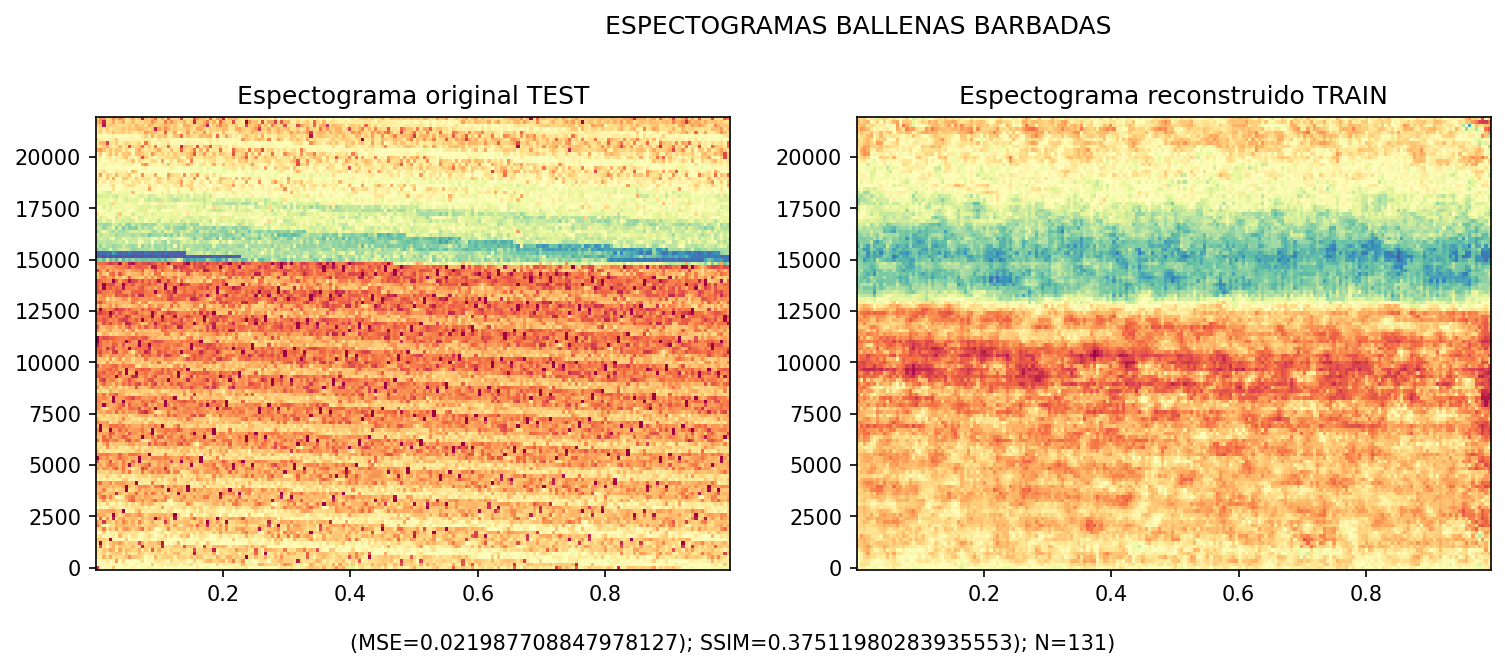

In [175]:
###---------------------------------------------------------------------------------------
#                              ADECUACIÓN DE LA IMAGEN DE TRAIN A COMPARAR
###---------------------------------------------------------------------------------------
#-------Se carga 1 SOLA imagen del conjunto de TEST y se la adecua para ingresar a la funcion que cuantifica el error.---
#Cargamos las imagenes a comparar. Esto carga UNA SOLA IMAGEN  del conjunto de TEST.
N=11                                          # Posición dentro del set de imagenes, de la imagen que quiere comparar
imagen_original_train=x_train[N,:]                   #N° imagen comparada: dimensión de los datos de entrada de test es: (128, 196, 1) y tipo array.
imagen_original= np.float32(imagen_original_train)  #Paso a float 32 para evitar un  warning que sale al comparar la imagen original con la reconstruida.

#Esta función me devuelve una tupla que contiene en: -[0] un tensor de todas las imagenes reconstruídas y en [1] la/las imagen/es codigo en el espacio latente.
    #La dimensión del dato de entrada debe ser (n,x,y,1), siendo n la cantidad de imagenes que se generan a la salida.
    #Para que sólo ingrese una imagen y se genere un sólo código, se debe agregar una cuarta dimension.
#imagen_original_4dim_tensor=tf.expand_dims(imagen_original, axis=0) #Esta función me devuelve un tensor, asique se debe pasar a array.
#imagen_original_4dim = tf.Session().run(imagen_original_4dim_tensor)

###---------------------------------------------------------------------------------------
#                              CÀLCULO DE ERRORES
###---------------------------------------------------------------------------------------
# print('En la posición RESULTADO[0] se encuentra el tensor de imagenes, cuya dimensión es:',np.shape(tratadas_todas[0]))
# print('En la posición RESULTADO[1] se encuentra el tensor del espacio latente, cuya dimensión es:',np.shape(tratadas_todas[1]))
#RESULTADO=autoencoder_CNN.reconstruct(imagen_original_4dim)  

RESULTADO=autoencoder_VAE.reconstruct(x_test)  ### Resultados de ingresar con todo el conjunto de datos de test al modelo entrenado.

aux=RESULTADO[0]   #matriz de imagenes de salida (n,128, 196, 1) para los datos de test
imagen_salida=aux[N,:]  #Reconstrucción de la primer imagen. La dimensión  es: (128, 196, 1)

# # Calcula el error cuadrático medio entre dos imagenes
MSE=skimage.measure.compare_mse(imagen_original,imagen_salida)
print('El error cuadrático medio es:',MSE)

# # #Calcula el índice SSIM entre dos imagenes
SSIM=skimage.measure.compare_ssim(imagen_original,imagen_salida,multichannel=True)
print('El índice SSIM es:',SSIM)

###---------------------------------------------------------------------------------------
#                             #GRAFICAR ESPECTOGRAMAS
###---------------------------------------------------------------------------------------
#Se cargan los ejes temporales. Estos datos se pueden obtener a partir de la frecuencia de muestreo y el tiempo, pero se obtienen directos de memoria. 
# Se generaron al realizar los espectogramas-
tiempo=np.load('C:/Users/el_lu/Desktop/proyectospython/DATOS/frecuencia.npy') # En Mint
frecuencia=np.load('C:/Users/el_lu/Desktop/proyectospython/DATOS/tiempo.npy')

#El tamaño de estos ejes se adecuada a la longitud de las imagenes.
tiempo1=tiempo[0:128]
frec1=frecuencia[0:196]

#La matriz que se debe pasar para el espectograma debe ser de 2 dimensiones.
original=imagen_original[:,:,0]     # Tendran la dimension (128,196)
reconstruida=imagen_salida[:,:,0]   # Tendran la dimension (128,196)

# Creando figura 
plt.figure(figsize=(12,4),dpi=150)
plt.subplot(1,2,1)
plt.text(0.8,26000,"ESPECTOGRAMAS BALLENAS BARBADAS", fontsize=12)
plt.text(0.4,-4000,"(MSE="+str(MSE)+"); SSIM="+str(SSIM)+"); N="+str(len(x_train[:,1,1]))+")",fontsize=10)
plt.title("Espectograma original TEST")
Pxx_original=plt.pcolormesh(frec1, tiempo1, original, cmap='Spectral')
plt.subplot(1,2,2)
plt.title("Espectograma reconstruido TRAIN")
Pxx_reconstruida=plt.pcolormesh(frec1, tiempo1, reconstruida, cmap='Spectral')

### GENERAR IMAGEN FICTICIA

In [49]:
#El código generado posee tantas subcódigos como datos fueron entrenados en el autoecoder y se obtendra una imagen similar.
# Los subcodigos son discretos, por ende debo enviarle un código en particular. 
#La elección del código ingresado podría hacerse de forma aleatoria.
import random

codigo=RESULTADO[1]
print(np.shape(codigo))
M=random.randint(0, len(codigo[:,0]))
print(M)
codigo_unico=codigo[M,:]
print(codigo_unico)
print(np.shape(codigo_unico),type(codigo_unico))

codigo_unico_tensor=tf.expand_dims(codigo_unico, axis=0) #Esta función me devuelve un tensor, asique se debe pasar a array.
codigo_unico_final= tf.compat.v1.Session().run(codigo_unico_tensor)

Imagen_final = autoencoder_VAE.Decoder.predict(codigo_unico_final)
#print(type(Imagen_final),np.shape(Imagen_final))

# tiempo1=tiempo[0:128]
# frec1=frecuencia[0:196]
# aux2=Imagen_final[0,:]
# aux3=aux2[:,:,0]
# print(np.shape(aux3))

# Pxx_original=plt.pcolormesh(frec1, tiempo1, aux3, cmap='Spectral')

(671, 2)
0
[-0.74141973  0.29792452]
(2,) <class 'numpy.ndarray'>


## AUTOENCODER MIXTO

La idea principal de esta arquitectura es dividir el procesamiento interno de los datos antes y después del cuello de botella o la representación del espacio latente. 
La división mencionada consiste en:
Una primera etapa donde se utiliza una arquitectura CNN: El objetivo es mantener el proceso de extracción de características de las "imágenes" 
(matriz del espectrograma) y, al mismo tiempo, se conserva la correlación local en los datos mediante el uso de kernels.
Una segunda etapa basada en LSTM RNN: LSTM RNN son bien conocidas en diferentes aplicaciones donde se van a procesar datos secuenciales. 
En este caso, se supone que estas capas descubren patrones de tiempo en los datos, que serán las diferentes características obtenidas de las capas 
convolucionales.
Posteriormente, para obtener un mapeo continuo a un espacio latente, se utiliza el enfoque presentado en el VAE de la versión anterior.

In [7]:
tf.compat.v1.disable_eager_execution()

### DEFINICIÓN DE LA ARQUITECTURA

In [8]:
class CRNN_VAE:
  """
  The present class refers to a Deep CRNN Variational AutoEncoder architecture
  where the encoder and the decoder components are mirrored.
  """
  def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 rec_layers,
                 lstm_cells,
                 latent_space_dim):
    
    """
    :param: input_shape = dimensions of the input data. In this case, Spectograms, MEL-Spectograms or
                          MFCSS will be fed into as grey-scale images.
    :param: conv_filters = Number of convolutional filters in each Convolutional layer.
    :param: conv_kernels = dimensions of the convolutional filters. In case, you consider all of
                           them of the same sizes.
    :param: conv_strides = Strides in the implementation of convolution to downsampling of the input data.
    :params: rec_layers = Number of LSTM Recurrent layers to include in the Encoder and Decoder stage.
    :params: lantet_space_dim = dimension of the latent space used as bottleneck between
                                the encoder and the decoder
    """
    self.input_shape = input_shape # [28, 28, 1]
    self.conv_filters = conv_filters # [2, 4, 8]
    self.conv_kernels = conv_kernels # [3, 5, 3]
    self.conv_strides = conv_strides # [1, 2, 2]
    self._num_rec_layers = rec_layers
    self.LSTM_cells = lstm_cells
    self.latent_space_dim = latent_space_dim # 2
    self.reconstruction_loss_weight = 1000


    self.Encoder = None
    self.Decoder = None
    self.Model = None
    self._model_input = None

    self._num_conv_layers = len(conv_filters) #Number of convolutional layers in the Model
    self._shape_before_bottleneck = None
    self._shape_before_recurrent_layers = None
    self.Dense_in_dim = None

    self._build()
  
  #definición del método para el modelo
  def _build(self):
    self._build_encoder() #Method to create the Encoder model
    self._build_decoder()
    self._build_autoencoder() 


  #----------------------------------------------
  #                   ENCODER
  #----------------------------------------------

  #Se define la construcción del codificador
  def _build_encoder(self):
    encoder_input = self._add_encoder_input() #Add input layer
    conv_layers = self._add_conv_layers(encoder_input) #Add all conv layers
    recurrent_layers = self._add_rec_layers(conv_layers)
    bottleneck = self._add_bottleneck(recurrent_layers) 
    self._model_input = encoder_input 
    self.Encoder = Model(encoder_input, bottleneck, name='Encoder_v3')

  def _add_encoder_input(self):
    return Input(
        shape = self.input_shape,
        name = "Encoder_Input_layer"
    )

 
  def _add_conv_layers(self, temp_model):
    """Creation of all convolutional layers in the model."""
    aux = temp_model
    #Add layer to layer to the model
    for layer in range(self._num_conv_layers):
      aux = self._add_conv_layer(layer,aux)
    return aux

  def _add_conv_layer(self, layer, temp_model):
    """
    Add a single convolutional layer to the model (temp_model)
    Each convolutional layer consist on:
    Conv2D: convolution with filters
    ReLU : activation function applied to the result of the convolution
    BatchNromalzation : Operation included to speed up the training process

    :param: layer: the actual layer index in the model building process
    :param: temp_model: the in-developing model to which the conv layer will be added 
    """

    layer_num = layer + 1
    conv_layer = Conv2D(
        filters=self.conv_filters[layer],
        kernel_size=self.conv_kernels[layer],
        strides=self.conv_strides[layer],
        padding="same", #Using padding "same" will help to track the evolution of the dimension of the tensors
        name=f"encoder_conv_layer_{layer}"
        )
    
    temp_model = conv_layer(temp_model)
    temp_model = ReLU(name=f"encoder_ReLU_layer_{layer}")(temp_model)
    temp_model = BatchNormalization(name=f"encoder_BN_layer_{layer}")(temp_model)
    return temp_model

  def _add_rec_layers(self, temp_model):
    """Creation of all recurrent layers in the model."""
    aux = temp_model
    self._shape_before_recurrent_layers = K.int_shape(temp_model)[1:]
    #First thing to do is to include a Reshape and Dense layers as interface between the recurrent and convolutional stages
    dim0 = np.floor(self.input_shape[0] / (np.prod(np.array(self.conv_strides))))
    dim0 = dim0.astype(int)
    dim1 = np.floor(self.input_shape[1] / (np.prod(np.array(self.conv_strides))))
    dim1 = dim1 * self.conv_filters[-1]
    dim1 = dim1.astype(int)
    #print('dim0:',dim0)
    #print('dim1:',dim1)
    self.Dense_in_dim = [dim0,dim1]
    aux = Reshape(
        target_shape = ((dim0,dim1)) # ((nro of time samples, frec_values(affected by kernels) x Nro_filter_last_conv_layer))
    )(aux)  #shape = (dim0,dim1)

    aux = Dense(
      units               = self.LSTM_cells,
      activation          = 'relu',
      use_bias            = True,
      kernel_initializer  = 'glorot_uniform',
      bias_initializer    ='zeros', 
      kernel_regularizer  =None,
      bias_regularizer    =None,
      activity_regularizer=None,
      kernel_constraint   =None,
      bias_constraint     =None, 
    )(aux)#shape = (dim0,self.LSTM_cells)    

    #Add layer to layer to the model
    for layer in range(self._num_rec_layers):
      aux = self._add_rec_layer(layer,aux)
      
    return aux

  def _add_rec_layer(self, layer, temp_model):
    """
    Add a single recurrent layer to the model (temp_model)
    Each recurrent layer consist on a LSTM layer

    :param: layer: the actual layer index in the model building process
    :param: temp_model: the in-developing model to which the recurrent layer will be added 
    """

    layer_num = layer + 1

    rec_layer = LSTM(
        units = self.LSTM_cells,
        return_sequences = True,
        name=f"encoder_rec_layer_{layer}"
        )
    
    temp_model = rec_layer(temp_model)
    return temp_model

    
  def _add_bottleneck(self, temp_model):
    """
    A Dense (fully connected) layer is added to the model to obtain the latent space.
    A Flatten layer must be added to reshape the output tensor of the convolutional layers
    to a vector suitable for a Dense layer.
    """

    #Information about the shape of the model before the latent space is stored
    #for the mirroring process while building the Decoder.
    self._shape_before_bottleneck = K.int_shape(temp_model)[1:]

    temp_model = Flatten()(temp_model)

    #The latent space is wrapped by a normal distribution
    #The normal distribution is completely defined by its mean valua and desviation
    self.mu = Dense(self.latent_space_dim, name = "mu_latent_space")(temp_model)
    self.log_variance = Dense(self.latent_space_dim, name = "log_variance_latent_space")(temp_model)
    
    
    def map_to_normal_distribution(args):
      mu, log_variance = args
      base_gaussian = K.random_normal(
        shape = K.shape(self.mu),
        mean = 0.,
        stddev = 1.
      )

      point = mu + K.exp(log_variance/2) * base_gaussian
      return point

    #Lambda layers are used to implement layers with a handmade function
    #In this case, the function will the parametrized normal distribution
    #whose parameters must be trained

    temp_model = Lambda(
        map_to_normal_distribution,
        name = "Encoder_output")([self.mu,self.log_variance])
 
    return temp_model

  #----------------------------------------------
  #                   DECODER
  #----------------------------------------------
  def _build_decoder(self):
    decoder_input = self._add_decoder_input()
    dense_layer = self._add_dense_layer(decoder_input)
    reshape_layer = self._add_reshape_layer(dense_layer)
    rec_transpose_layers = self._add_rec_transpose_layers(reshape_layer)
    reshape_conv_transpose_layer = self._add_reshape_conv_transpose_layer(rec_transpose_layers)
    conv_transpose_layers = self._add_conv_transpose_layers(reshape_conv_transpose_layer)
    decoder_output = self._add_decoder_output(conv_transpose_layers)
    self.Decoder = Model(decoder_input, decoder_output, name="Decoder_v3")

  def _add_decoder_input(self):
    return Input(
        shape = self.latent_space_dim,
        name = "Decoder_input_layer"
    )

  def _add_dense_layer(self, temp_model):
    dense_layer = Dense(
        np.prod(self._shape_before_bottleneck),
        name = "Decoder_dense_layer"
    )(temp_model)
    return dense_layer

  def _add_reshape_layer(self,temp_model):
    return Reshape(self._shape_before_bottleneck)(temp_model)
  
  def _add_rec_transpose_layers(self, temp_model):
    """Creation of all recurrent layers in the model."""
    aux = temp_model
    #Add layer to layer to the model
    for layer in range(self._num_rec_layers):
      aux = self._add_rec_transpose_layer(layer,aux)
      
    return aux

  def _add_rec_transpose_layer(self, layer, temp_model):
    """
    Add a single recurrent layer to the model (temp_model)
    Each recurrent layer consist on a LSTM layer

    :param: layer: the actual layer index in the model building process
    :param: temp_model: the in-developing model to which the recurrent layer will be added 
    """

    layer_num = layer + 1

    rec_layer = LSTM(
        units = self.LSTM_cells,
        return_sequences = True,
        name=f"Dencoder_rec_transpose_layer_{layer}"
        )
    
    temp_model = rec_layer(temp_model)

    return temp_model

  def _add_reshape_conv_transpose_layer(self, temp_model):
    aux = temp_model
    aux = Dense(
      units               = self.Dense_in_dim[1],
      activation          = 'relu',
      use_bias            = True,
      kernel_initializer  = 'glorot_uniform',
      bias_initializer    ='zeros', 
      kernel_regularizer  =None,
      bias_regularizer    =None,
      activity_regularizer=None,
      kernel_constraint   =None,
      bias_constraint     =None, 
    )(aux)#shape = (dim0,self.LSTM_cells) 

    return Reshape(self._shape_before_recurrent_layers)(aux)

  def _add_conv_transpose_layers(self, temp_model):
    """ Add all the transpose convolutional layers to the model"""
    for layer in reversed(range( 1, self._num_conv_layers)):
      temp_model = self._add_conv_transpose_layer(layer,temp_model)

    return temp_model

  def _add_conv_transpose_layer(self,layer,temp_model):
    """Add a single transpose conv layer to the model """

    layer_num = self._num_conv_layers - layer

    conv_transpose_layer = Conv2DTranspose(
        filters = self.conv_filters[layer],
        kernel_size=self.conv_kernels[layer],
        strides=self.conv_strides[layer],
        padding="same",
        name=f"decoder_conv_transpose_layer_{layer}"
        )
    
    temp_model = conv_transpose_layer(temp_model)
    temp_model = ReLU(name =f"decoder_ReLU_transpose_layer_{layer}")(temp_model)
    temp_model = BatchNormalization(name = f"decoder_BN_transpose_layer_{layer}")(temp_model)

    return temp_model

  
  def _add_decoder_output(self, temp_model):

     conv_transpose_layer = Conv2DTranspose(
            filters=1,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
        )
     temp_model = conv_transpose_layer(temp_model)
     output_layer = Activation("sigmoid", name="sigmoid_layer")(temp_model)
    
     return output_layer



  #----------------------------------------------
  #                   AUTOENCODER
  #----------------------------------------------
  def _build_autoencoder(self):
    model_input = self._model_input
    model_output = self.Decoder(self.Encoder(model_input))
    self.Model = Model(model_input, model_output, name="CRNN_Variational_AutoEncoder_v1")

  #----------------------------------------------
  #            COMPILATION AND TRAINING
  #----------------------------------------------
  def compile1(self, loss_function = "MSE",learning_rate=0.0001):
        optimizer = Adam(learning_rate=learning_rate)
        self.Model.compile(optimizer=optimizer,
                              loss=self._calculate_combined_loss,
                              metrics= [self._calculate_reconstruction_loss, self._calculate_kl_loss] #Metrics are evaluated by the model during training and testing.
                              )
  
  def _calculate_combined_loss(self, y_target, y_predicted):
    """
    the reconstruction loss weight may be optimized during the training process or using some hyperparameter optimization method
    """
    reconstruction_loss = self._calculate_reconstruction_loss(y_target, y_predicted)
    kl_loss = self._calculate_kl_loss(y_target, y_predicted)
    combined_loss = self.reconstruction_loss_weight * reconstruction_loss + kl_loss
    return combined_loss

  def _calculate_reconstruction_loss(self, y_target, y_predicted):
    error = y_target - y_predicted
    reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])
    return reconstruction_loss

  def _calculate_kl_loss(self, y_target, y_predicted):
    """
    The main objetive of KL loss is to take the resulting multivariational distribution the closest possible to
    a standard normal distribution. It also improves the symmetry around the origin, which helps to avoid gaps in the
    latent space.
    """
    kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu) - K.exp(self.log_variance), axis=1)
    return kl_loss


  def train(self, x_train, batch_size, num_epochs, porcentaje_validacion):
        History=self.Model.fit(x_train,
                       x_train,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       validation_split=porcentaje_validacion,
                       shuffle=True)

        return History
  #----------------------------------------------
  #                   STRUCTURE SUMMARY
  #----------------------------------------------

  def summary(self):
      self.Encoder.summary()
      self.Decoder.summary()
      self.Model.summary()

  #----------------------------------------------
  #                   SAVE THE MODEL
  #----------------------------------------------
  def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

  def _create_folder_if_it_doesnt_exist(self, folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

  def _save_parameters(self, save_folder):
      parameters = [
          self.input_shape,
          self.conv_filters,
          self.conv_kernels,
          self.conv_strides,
          self.latent_space_dim
      ]
      save_path = os.path.join(save_folder, "parameters.pkl")
      with open(save_path, "wb") as f:
          pickle.dump(parameters, f)

  def _save_weights(self, save_folder):
      save_path = os.path.join(save_folder, "weights.h5py")
      self.Model.save_weights(save_path)

  #----------------------------------------------
  #                   LOAD THE MODEL
  #----------------------------------------------
  def load_weights(self, weights_path):
    self.Model.load_weights(weights_path)

  @classmethod
  def load(cls, save_folder="."):
    parameters_path = os.path.join(save_folder, "parameters.pkl")
    with open(parameters_path, "rb") as f:
        parameters = pickle.load(f)
    autoencoder = CRNN_VAE(*parameters)
    weights_path = os.path.join(save_folder, "weights.h5py")
    autoencoder.load_weights(weights_path)
    return autoencoder

  #----------------------------------------------
  #                   PREDICTION
  #----------------------------------------------
  def reconstruct(self, images):
    latent_representations = self.Encoder.predict(images)
    reconstructed_images = self.Decoder.predict(latent_representations)
    return reconstructed_images, latent_representations

### ARQUITECTURA ESPECIFICA

In [21]:
autoencoder_CRNN = CRNN_VAE(
        input_shape= (input_shape[0],input_shape[1], 1),
        conv_filters=(32, 64, 64, 64),
        conv_kernels=(3, 3, 3, 3),
        conv_strides=(1, 2, 2, 1),
        rec_layers = 2,
        lstm_cells = 16,
        latent_space_dim=4
    )
autoencoder_CRNN.summary()




Model: "Encoder_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Input_layer (InputLayer [(None, 128, 196, 1) 0                                            
__________________________________________________________________________________________________
encoder_conv_layer_0 (Conv2D)   (None, 128, 196, 32) 320         Encoder_Input_layer[0][0]        
__________________________________________________________________________________________________
encoder_ReLU_layer_0 (ReLU)     (None, 128, 196, 32) 0           encoder_conv_layer_0[0][0]       
__________________________________________________________________________________________________
encoder_BN_layer_0 (BatchNormal (None, 128, 196, 32) 128         encoder_ReLU_layer_0[0][0]       
_________________________________________________________________________________________

### ENTRENAMIENTO

In [22]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 40
EPOCHS =60
autoencoder_CRNN.compile1(LEARNING_RATE)
History=autoencoder_CRNN.train(x_train,BATCH_SIZE,EPOCHS,0.2)


Train on 4833 samples, validate on 1209 samples
Epoch 1/60
4833/4833 [==============================] - 319s 66ms/sample - loss: 77.6005 - _calculate_reconstruction_loss: 0.0775 - _calculate_kl_loss: 0.0706 - val_loss: 42.1829 - val__calculate_reconstruction_loss: 0.0421 - val__calculate_kl_loss: 0.0543
Epoch 2/60
4833/4833 [==============================] - 362s 75ms/sample - loss: 56.8596 - _calculate_reconstruction_loss: 0.0568 - _calculate_kl_loss: 0.0217 - val_loss: 40.4552 - val__calculate_reconstruction_loss: 0.0404 - val__calculate_kl_loss: 0.0143
Epoch 3/60
4833/4833 [==============================] - 369s 76ms/sample - loss: 45.6725 - _calculate_reconstruction_loss: 0.0457 - _calculate_kl_loss: 0.0132 - val_loss: 47.6556 - val__calculate_reconstruction_loss: 0.0476 - val__calculate_kl_loss: 0.0109
Epoch 4/60
4833/4833 [==============================] - 369s 76ms/sample - loss: 44.4769 - _calculate_reconstruction_loss: 0.0445 - _calculate_kl_loss: 0.0097 - val_loss: 48.8515 - 

### EVALUACIÓN DEL MODELO

NameError: name 'History' is not defined

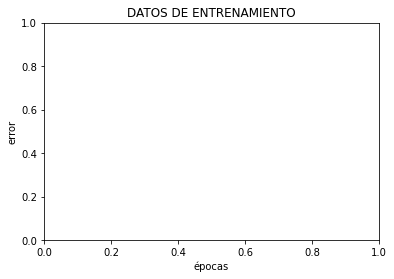

In [9]:
import matplotlib 
from matplotlib import pyplot as plt

fig = plt.figure()
plt.title("DATOS DE ENTRENAMIENTO")
plt.ylabel('error')
plt.xlabel('épocas')
plt.plot(History.history["_calculate_reconstruction_loss"], label="Training reconstruction_Loss")
plt.plot(History.history["val__calculate_reconstruction_loss"], label="Validation reconstructio Loss")
plt.legend()

In [103]:
print(History.history["_calculate_reconstruction_loss"])


[0.07821635, 0.057893164, 0.04600761, 0.044488706, 0.044452656, 0.044441983, 0.04444251, 0.04444306, 0.04444618, 0.044445887, 0.044444125, 0.04444219, 0.044439126, 0.044439726, 0.04444653, 0.044438723, 0.04444702, 0.044440694, 0.044442873, 0.044447474, 0.044445608, 0.044445984, 0.044452112, 0.044449262, 0.044451017, 0.044445943, 0.0444435, 0.044449896, 0.044443604, 0.04443644, 0.044467248, 0.044454686, 0.044449598, 0.04444316, 0.04444282, 0.044441078, 0.04445091, 0.044442426, 0.044444192, 0.044449188, 0.04444766, 0.044467892, 0.04444638, 0.04444336, 0.044447448, 0.044435117, 0.044442277, 0.044445273, 0.044441685, 0.04445428, 0.04445121, 0.04445849, 0.044442598, 0.04444749, 0.04444901, 0.04445024, 0.044440906, 0.044442914, 0.04444632, 0.044448707]


### GUARDAR DATOS DE TRAIN

In [16]:
error_train=History.history["_calculate_reconstruction_loss"]
error_train_save=np.save('C:/Users/el_lu/Desktop/proyectospython/Autoencoders/vectores_error/train_ballena_mixto(60epoch_2rec_16cel_DIM2)_24_10_2022.npy',error_train)

error_validation=History.history["val__calculate_reconstruction_loss"]
error_validation_save=np.save('C:/Users/el_lu/Desktop/proyectospython/Autoencoders/vectores_error/val_ballena_mixto(60epoch_2rec_16cel_DIM2)_24_10_2022.npy',error_validation)

### GUARDAR MODELO

In [17]:
autoencoder_CRNN.save("C:/Users/el_lu/Desktop/proyectospython/MIX_BALLENA(60epoch2_dim2_celdas16)")  #especificar carpeta LINUX

#### CARGAR EL MODELO

In [11]:
autoencoder_LSTM = CRNN_VAE.LSTM("C:/Users/el_lu/Desktop/proyectospython/MIX_BALLENA(60epoch1-16_dim3)") 

AttributeError: type object 'CRNN_VAE' has no attribute 'LSTM'

In [12]:
input_shape = [128,196]
autoencoder_LSTM = CRNN_VAE(
        input_shape= (input_shape[0],input_shape[1], 1),
        conv_filters=(32, 64, 64, 64),
        conv_kernels=(3, 3, 3, 3),
        conv_strides=(1, 2, 2, 1),
        rec_layers = 1,
        lstm_cells = 16,
        latent_space_dim=3
    )
save_folder = "C:/Users/el_lu/Desktop/proyectospython/MIX_BALLENA(60epoch1-16_dim3)"
weights_path = os.path.join(save_folder, "weights.h5py")
autoencoder_LSTM.load_weights(weights_path)


### GRÁFICOS DE TEST

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


c:\ProgramData\Anaconda3\envs\env_tensorflow2-3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.
c:\ProgramData\Anaconda3\envs\env_tensorflow2-3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


El error cuadrático medio es: 0.007541276889890448
El índice SSIM es: 0.539031739768916


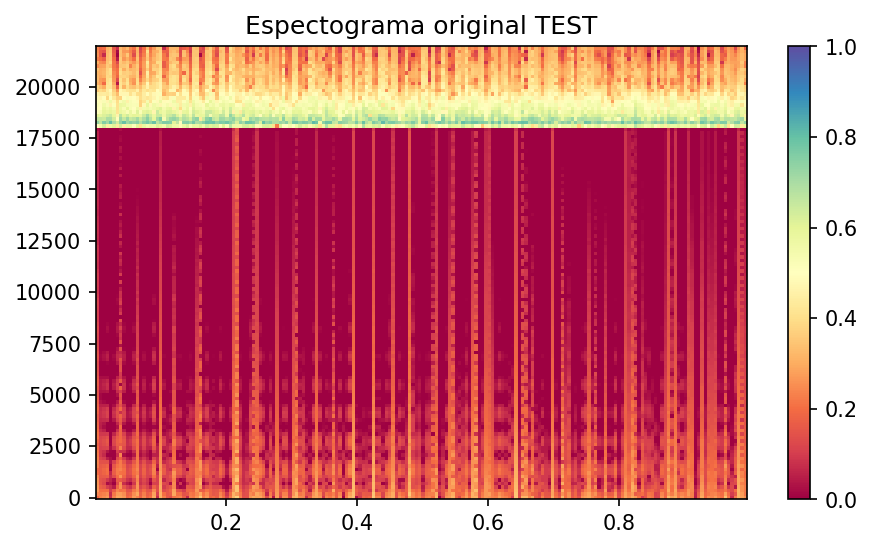

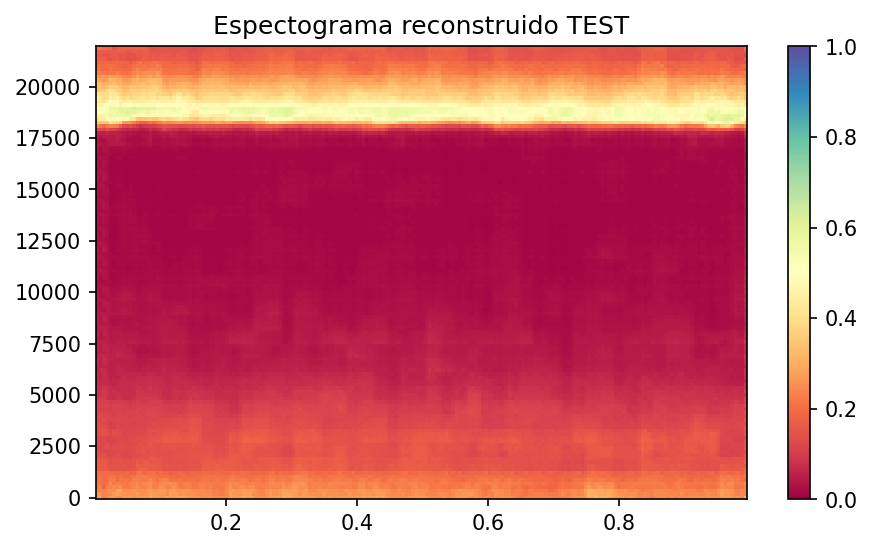

In [20]:
###---------------------------------------------------------------------------------------
#                              ADECUACIÓN DE LA IMAGEN DE TEST A COMPARAR
###---------------------------------------------------------------------------------------
#-------Se carga 1 SOLA imagen del conjunto de TEST y se la adecua para ingresar a la funcion que cuantifica el error.---
#Cargamos las imagenes a comparar. Esto carga UNA SOLA IMAGEN  del conjunto de TEST.
N=40 # Posición dentro del set de imagenes, de la imagen que quiere comparar
imagen_original_test=x_test[N,:]                   #N° imagen comparada: dimensión de los datos de entrada de test es: (128, 196, 1) y tipo array.
imagen_original= np.float32(imagen_original_test)  #Paso a float 32 para evitar un  warning que sale al comparar la imagen original con la reconstruida.

#Esta función me devuelve una tupla que contiene en: -[0] un tensor de todas las imagenes reconstruídas y en [1] la/las imagen/es codigo en el espacio latente.
    #La dimensión del dato de entrada debe ser (n,x,y,1), siendo n la cantidad de imagenes que se generan a la salida.
    #Para que sólo ingrese una imagen y se genere un sólo código, se debe agregar una cuarta dimension.
#imagen_original_4dim_tensor=tf.expand_dims(imagen_original, axis=0) #Esta función me devuelve un tensor, asique se debe pasar a array.
#imagen_original_4dim = tf.Session().run(imagen_original_4dim_tensor)

###---------------------------------------------------------------------------------------
#                              CÀLCULO DE ERRORES
###---------------------------------------------------------------------------------------
# print('En la posición RESULTADO[0] se encuentra el tensor de imagenes, cuya dimensión es:',np.shape(tratadas_todas[0]))
# print('En la posición RESULTADO[1] se encuentra el tensor del espacio latente, cuya dimensión es:',np.shape(tratadas_todas[1]))
#RESULTADO=autoencoder_CNN.reconstruct(imagen_original_4dim)  

RESULTADO=autoencoder_LSTM.reconstruct(x_test)  ### Resultados de ingresar con todo el conjunto de datos de test al modelo entrenado.

aux=RESULTADO[0]   #matriz de imagenes de salida (n,128, 196, 1) para los datos de test
imagen_salida=aux[N,:]  #Reconstrucción de la primer imagen. La dimensión  es: (128, 196, 1)

# # Calcula el error cuadrático medio entre dos imagenes
MSE=skimage.measure.compare_mse(imagen_original,imagen_salida)
print('El error cuadrático medio es:',MSE)

# # #Calcula el índice SSIM entre dos imagenes
SSIM=skimage.measure.compare_ssim(imagen_original,imagen_salida,multichannel=True)
print('El índice SSIM es:',SSIM)

###---------------------------------------------------------------------------------------
#                             #GRAFICAR ESPECTOGRAMAS
###---------------------------------------------------------------------------------------
#Se cargan los ejes temporales. Estos datos se pueden obtener a partir de la frecuencia de muestreo y el tiempo, pero se obtienen directos de memoria. 
# Se generaron al realizar los espectogramas-
tiempo=np.load('C:/Users/el_lu/Desktop/proyectospython/DATOS/frecuencia.npy') # En Mint
frecuencia=np.load('C:/Users/el_lu/Desktop/proyectospython/DATOS/tiempo.npy')

#El tamaño de estos ejes se adecuada a la longitud de las imagenes.
tiempo1=tiempo[0:128]
frec1=frecuencia[0:196]

#La matriz que se debe pasar para el espectograma debe ser de 2 dimensiones.
original=imagen_original[:,:,0]     # Tendran la dimension (128,196)
reconstruida=imagen_salida[:,:,0]   # Tendran la dimension (128,196)

# Creando figura 
plt.figure(figsize=(7,4),dpi=150)
#plt.subplot(1,2,1)
#plt.text(0.8,26000,"ESPECTOGRAMAS BALLENAS BARBADAS", fontsize=12)
#plt.text(0.4,-4000,"(MSE="+str(MSE)+"); SSIM="+str(SSIM)+"); N="+str(len(x_train[:,1,1]))+")",fontsize=10)
plt.title("Espectograma original TEST")
Pxx_original=plt.pcolormesh(frec1, tiempo1, original,  vmin=0, vmax=1, cmap='Spectral')
plt.colorbar()
plt.figure(figsize=(7,4),dpi=150)#
plt.title("Espectograma reconstruido TEST")
Pxx_reconstruida=plt.pcolormesh(frec1, tiempo1, reconstruida, vmin=0, vmax=1,  cmap='Spectral')
plt.colorbar()

### GENERAR IMAGENES FICTICIAS

In [29]:
codigo=RESULTADO[1]  # Codigo del espacio latente
print (np.shape(codigo))  #Dimensión del espacio latente. Se generan X cantidad de vectores de dim=3

latent_space_LSTM_0 = codigo[:,0]   # El valor de la posición 0, de todos los codigos generados
latent_space_LSTM_1 = codigo[:,1]   # El valor de la posición 1, de todos los codigos generados
latent_space_LSTM_2 = codigo[:,2]   # El valor de la posición 2, de todos los codigos generados





(672, 3)


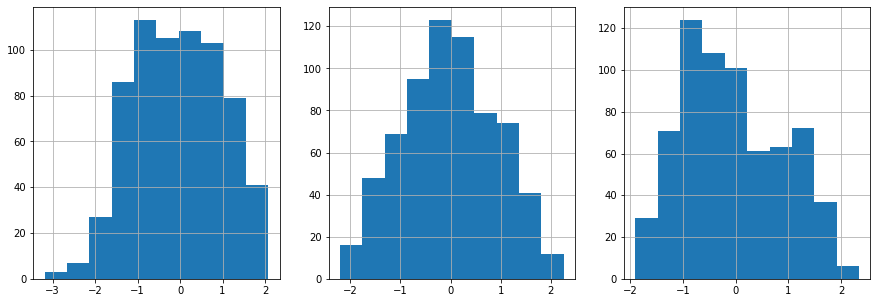

In [30]:
#HISTOGRAMAS DE LA DISTRIBUCION DE CADA VALOR DEL LATENT SPACE
fig1, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(15,5))

#Histograma del primer vector del latent space del CNN_transfer
ax0.hist(latent_space_LSTM_0)
ax0.grid(True)

#Histograma del primer vector del latent space del CNN_transfer
ax1.hist(latent_space_LSTM_1)
ax1.grid(True)

#Histograma del primer vector del latent space del CNN_transfer
ax2.hist(latent_space_LSTM_2)
ax2.grid(True)


plt.show()

(6043, 3)


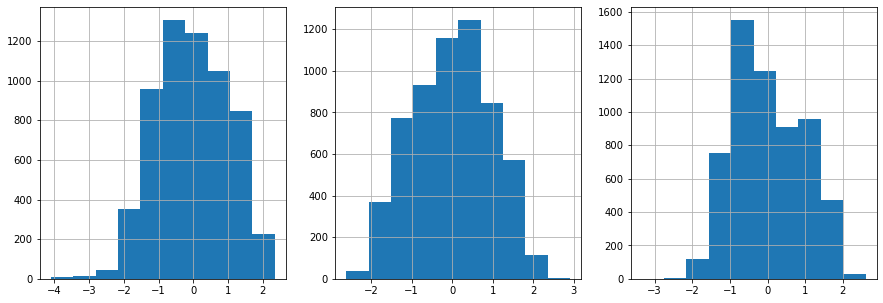

In [80]:
#CON LOS VALORES DE TRAIN

RESULTADO=autoencoder_LSTM.reconstruct(x_train)
codigo=RESULTADO[1]  # Codigo del espacio latente
print (np.shape(codigo))  #Dimensión del espacio latente. Se generan X cantidad de vectores de dim=3

latent_space_LSTM_0 = codigo[:,0]   # El valor de la posición 0, de todos los codigos generados
latent_space_LSTM_1 = codigo[:,1]   # El valor de la posición 1, de todos los codigos generados
latent_space_LSTM_2 = codigo[:,2]   # El valor de la posición 2, de todos los codigos generados


fig1, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(15,5))

#Histograma del primer vector del latent space del CNN_transfer
ax0.hist(latent_space_LSTM_0)
ax0.grid(True)

#Histograma del primer vector del latent space del CNN_transfer
ax1.hist(latent_space_LSTM_1)
ax1.grid(True)

#Histograma del primer vector del latent space del CNN_transfer
ax2.hist(latent_space_LSTM_2)
ax2.grid(True)


plt.show()

#### VALOR MEDIO, VARIANZA Y DESVIACION

In [81]:
# VALOR MEDIO Y VARIANZA

valor_medio_0 = np.mean(latent_space_LSTM_0)
valor_medio_1 = np.mean(latent_space_LSTM_1)
valor_medio_2 = np.mean(latent_space_LSTM_2)

print ('Valor medio del vector 0:', valor_medio_0)
print ('Valor medio del vector 1:', valor_medio_1)
print ('Valor medio del vector 2:', valor_medio_2)

# Valores de las desviaciones estandar
desviacion_estandar_0 = np.std(latent_space_LSTM_0)
desviacion_estandar_1 = np.std(latent_space_LSTM_1)
desviacion_estandar_2 = np.std(latent_space_LSTM_2)

print ('Desviación estandar del vector 0:', desviacion_estandar_0)
print ('Desviación estandar del vector 1:', desviacion_estandar_1)
print ('Desviación estandar del vector 2:', desviacion_estandar_2)

# Valores de las Varianzas
varianza_0 = latent_space_LSTM_0.var()
varianza_1 = latent_space_LSTM_1.var()
varianza_2 = latent_space_LSTM_2.var()


print ('Varianza del vector 0:', varianza_0)
print ('Varianza del vector 1:', varianza_1)
print ('Varianza del vector 2:', varianza_2)


Valor medio del vector 0: -0.03642605
Valor medio del vector 1: 0.0005867876
Valor medio del vector 2: 0.016312232
Desviación estandar del vector 0: 1.0340301
Desviación estandar del vector 1: 0.97501695
Desviación estandar del vector 2: 0.9265404
Varianza del vector 0: 1.0692182
Varianza del vector 1: 0.9506581
Varianza del vector 2: 0.85847706


#### MATRIZ CORRELACIÓN

In [82]:
import pandas as pd

df = pd.DataFrame(codigo, columns=['X0','X1','X2'])
df.corr()

,X0,X1,X2
X0,1.000000,-0.018347,-0.115915
X1,-0.018347,1.000000,-0.019709
X2,-0.115915,-0.019709,1.000000


#### HISTOGRAMAS Y PDF´S NORMALIZADAS

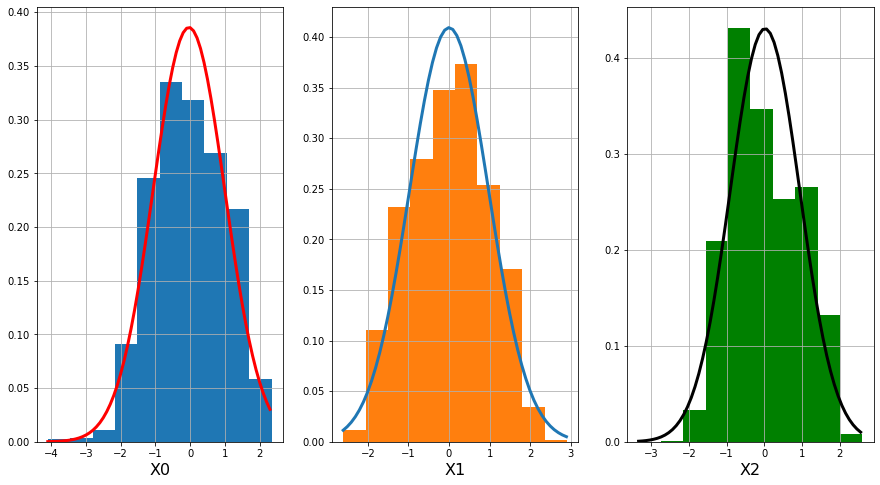

In [83]:
from scipy.stats import norm

x_axis_0 = np.arange(latent_space_LSTM_0.min(),latent_space_LSTM_0.max(),0.1)
x_axis_1 = np.arange(latent_space_LSTM_1.min(),latent_space_LSTM_1.max(),0.1)
x_axis_2 = np.arange(latent_space_LSTM_2.min(),latent_space_LSTM_2.max(),0.1)
x_axis = np.arange(-1000,1000,0.1)

fig2, ax2 = plt.subplots(1,3,figsize = (15,8))

ax2[0].plot(x_axis_0, norm.pdf(x_axis_0, valor_medio_0, np.sqrt(varianza_0)), linewidth = 3, color = 'r')
ax2[0].hist(latent_space_LSTM_0, density=True, color = 'tab:blue')
ax2[0].plot()
##ax2[0].tick_params(axis='x', labelsize=12)
#ax2[0].tick_params(axis='y', labelsize=12)
ax2[0].set_xlabel('X0', fontsize = 16)
#ax2[0].set_title('Histograma y pdf normalizada', fontsize = 18)
ax2[0].grid(True)

ax2[1].plot(x_axis_1, norm.pdf(x_axis_1, valor_medio_1, np.sqrt(varianza_1)), linewidth = 3)
ax2[1].hist(latent_space_LSTM_1, density=True)
ax2[1].set_xlabel('X1', fontsize = 16)
ax2[1].grid(True)

ax2[2].plot(x_axis_2, norm.pdf(x_axis_2, valor_medio_2, np.sqrt(varianza_2)), linewidth = 3, color = 'black')
ax2[2].hist(latent_space_LSTM_2, density=True, color = 'g')
ax2[2].set_xlabel('X2', fontsize = 16)
ax2[2].grid(True)


plt.show()

#### GENERAR IMAGENES

[-1.12625535 -0.91840522  0.58286181]
(1, 128, 196, 1)
(128, 196)


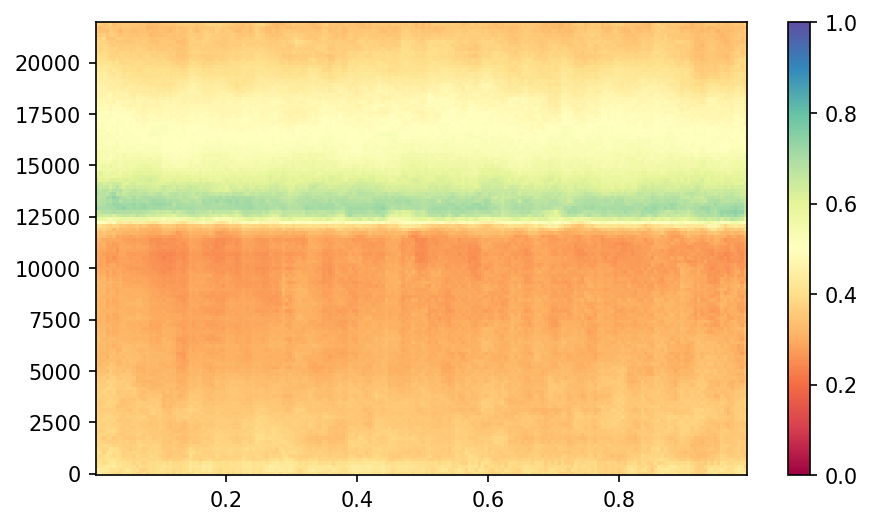

In [79]:
import random

X_0= random.gauss(valor_medio_0,desviacion_estandar_0)
X_1= random.gauss(valor_medio_1,desviacion_estandar_1)
X_2= random.gauss(valor_medio_2,desviacion_estandar_2)

vector_generador=np.array([X_0,X_1,X_2])
print(vector_generador)

#esto lo tengo que hacer para que de la dimensión necesaria en PREDICT.
codigo_unico_tensor=tf.expand_dims(vector_generador, axis=0) #Esta función me devuelve un tensor, asique se debe pasar a array.
codigo_unico_final= tf.compat.v1.Session().run(codigo_unico_tensor)

Imagen_final = autoencoder_LSTM.Decoder.predict(codigo_unico_final)
print(np.shape(Imagen_final))
ficticia=Imagen_final[0,:,:,0]
print(np.shape(ficticia))

plt.figure(figsize=(7,4),dpi=150)
#plt.subplot(1,2,1)
#plt.text(0.8,26000,"ESPECTOGRAMAS BALLENAS BARBADAS", fontsize=12)
#plt.text(0.4,-4000,"(MSE="+str(MSE)+"); SSIM="+str(SSIM)+"); N="+str(len(x_train[:,1,1]))+")",fontsize=10)
#plt.title("Espectograma original TEST")
Pxx_original=plt.pcolormesh(frec1, tiempo1, ficticia,  vmin=0, vmax=1, cmap='Spectral')
plt.colorbar()